In [1]:
# import sys
# !{sys.executable} python3 -m ensurepip --upgrade
# !{sys.executable} python3 -m pip install pynbody
# !{sys.executable} python3 -m pip install https://bitbucket.org/yymao/helpers/get/master.zip
# !{sys.executable} python3 -m pip install emcee
# !{sys.executable} python3 -m pip install ChainConsumer
# !{sys.executable} python3 -m pip install corner
# !{sys.executable} python3 -m pip install tqdm
# !{sys.executable} python3 -m pip install scikit-image
# !{sys.executable} python3 -m pip install scikit-learn

In [2]:
import numpy as np
import pickle
import pynbody
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt
import pylab
import scipy.special
import scipy.stats
from scipy.interpolate import griddata
import emcee
import corner
from chainconsumer import ChainConsumer#, Chain, make_sample
from scipy.special import factorial
import sklearn
import scipy
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.integrate import trapezoid

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_bluegreens = ["#99FFDD","#66FFCC", "#33FFBB", "#00FFAA", "#00CC88", "#009966", "#006644", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]
custom_cet_fdm = ["#EE99FF","#E566FF","#DD33FF","#D400FF","#AA00CC","#7F0099","#550066"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['wdm_3'] = custom_blues_complement[1]
sim_colors['wdm_4'] = custom_blues_complement[2]
sim_colors['wdm_5'] = custom_blues_complement[3]
sim_colors['wdm_6'] = custom_blues_complement[4]
sim_colors['wdm_6.5'] = custom_blues_complement[5]
sim_colors['wdm_10'] = custom_blues_complement[6]
sim_colors['idm_n2_1e-4GeV'] = custom_blues[2]
sim_colors['idm_n2_1e-2GeV'] = custom_blues[4]
sim_colors['idm_n2_1GeV'] = custom_blues[6]
sim_colors['idm_1e-4GeV'] = custom_bluegreens[2]
sim_colors['idm_1e-2GeV'] = custom_bluegreens[4]
sim_colors['idm_1GeV'] = custom_bluegreens[6]
sim_colors['fdm_25.9e-22eV'] = custom_cet_fdm[1]
sim_colors['fdm_69.4e-22eV'] = custom_cet_fdm[2]
sim_colors['fdm_113e-22eV'] = custom_cet_fdm[3]
sim_colors['fdm_151e-22eV'] = custom_cet_fdm[4]
sim_colors['fdm_185e-22eV'] = custom_cet_fdm[5]
sim_colors['fdm_490e-22eV'] = custom_cet_fdm[6]
sim_colors['running_10'] = 'teal'
sim_colors['running_1'] = 'goldenrod'

plt.rc("text", usetex=True)
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams["xtick.major.size"]  = 8
plt.rcParams["xtick.minor.size"]  = 3
plt.rcParams["ytick.major.size"]  = 8
plt.rcParams["ytick.minor.size"]  = 3
plt.rcParams["xtick.direction"]  = "out"
plt.rcParams["ytick.direction"]  = "out"
plt.rcParams["legend.frameon"] = 'False'

linestyles = {'envelope':'--','halfmode':'-'}

### Load simulation data

In [2]:
with open("/central/groups/carnegie_poc/enadler/ncdm_resims/analysis/sim_data.bin", "rb") as f:
    sim_data = pickle.load(f, encoding='latin1')

halo_nums = ['Halo004', 'Halo113', 'Halo023']
models = ['idm_n2_1e-4GeV','idm_n2_1e-2GeV','idm_n2_1GeV','idm_1e-4GeV','idm_1e-2GeV','idm_1GeV','cdm']
methods = ['halfmode', 'envelope']
masses = {'wdm_3': 3., 'wdm_4': 4., 'wdm_5': 5., 'wdm_6': 6., 'wdm_6.5': 6.5, 'wdm_10': 10., 'cdm': 1000.}

In [3]:
h = 0.7
omega_m = 0.286
rho_crit = 1.36*10**11*omega_m #msun/Mpc^3

def khm(mwdm):
    alpha = 0.049
    if mwdm >= 3.:
        alpha = 0.045
    elif mwdm > 6.:
        alpha = 0.043
    lambda_fs = (alpha*(mwdm**(-1.11))*((omega_m/0.25)**(0.11))*((h/0.7)**1.22))
    lambda_hm = 13.93*lambda_fs
    k_hm = 2*np.pi/lambda_hm
    return k_hm

def Mhm_k(khm):
    lambda_hm = 2*np.pi/khm
    return (4./3.)*np.pi*rho_crit*(lambda_hm/(2.*0.7))**3.

#Note that this is updated!
def Mhm(mwdm):
    return 4.3e8 * (mwdm/3.)**(-3.564)
#     return (4.*np.pi*rho_crit/3.)*((2.*np.pi/(khm(mwdm)*0.7))/2.)**3.

def mwdm(Mhm):
    return 3.*(Mhm/4.3e8)**(-1./3.564)
    # alpha = 0.049
    # if mwdm >= 3.:
    #     alpha = 0.045
    # elif mwdm > 6.:
    #     alpha = 0.043
    # lambda_hm = 2.*(((3./4)*Mhm/(np.pi*rho_crit))**(1./3))
    # lambda_fs = lambda_hm/13.93
    # mwdm = (h*lambda_fs/(alpha*((omega_m/0.25)**(0.11))*((h/0.7)**1.22)))**(1./-1.11)
    # return mwdm

def transfer(k,mwdm):
    nu = 1.12
    p = 0.049
    if mwdm >= 3.:
        p = 0.045
    elif mwdm > 6.:
        p = 0.043
    lambda_fs = (p*(mwdm**(-1.11))*((omega_m/0.25)**(0.11))*((h/0.7)**1.22))
    alpha = lambda_fs
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

def fdm_schive(Mpeak,m22,alpha=-1.1,beta=-2.2):
    M0 = 1.6*10**10*(m22**(-4./3.))
    return (1+(Mpeak/M0)**alpha)**beta

In [4]:
def get_shmf(masses,bins):
    values_mpeak, base_mpeak = np.histogram(masses,bins)
    return values_mpeak/(base_mpeak[1:]-base_mpeak[0:-1]), values_mpeak, base_mpeak

base_mpeak = np.logspace(np.log10(3e5*300/0.7),np.log10(9e5*1.3e5/0.7),7)
x=0.5*(base_mpeak[1:]+base_mpeak[:-1])

In [5]:
def dNdlogMpeak(a,b,alpha,beta,gamma,x2,integrals,host,key):
    return (1.-np.array(integrals))*(a/100)*(10.**x2/(host['mvir'][0]/0.7))**(-1.*b)*np.exp(-50.*(10.**x2/(host['mvir'][0]/0.7))**(4.))*(1.+(alpha*Mhm(masses[key])/10.**x2)**beta)**(-1.*gamma)

/tmp/ipykernel_3717670/904168356.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=4,fontsize=16,frameon=False,framealpha=1.0,ncol=2)


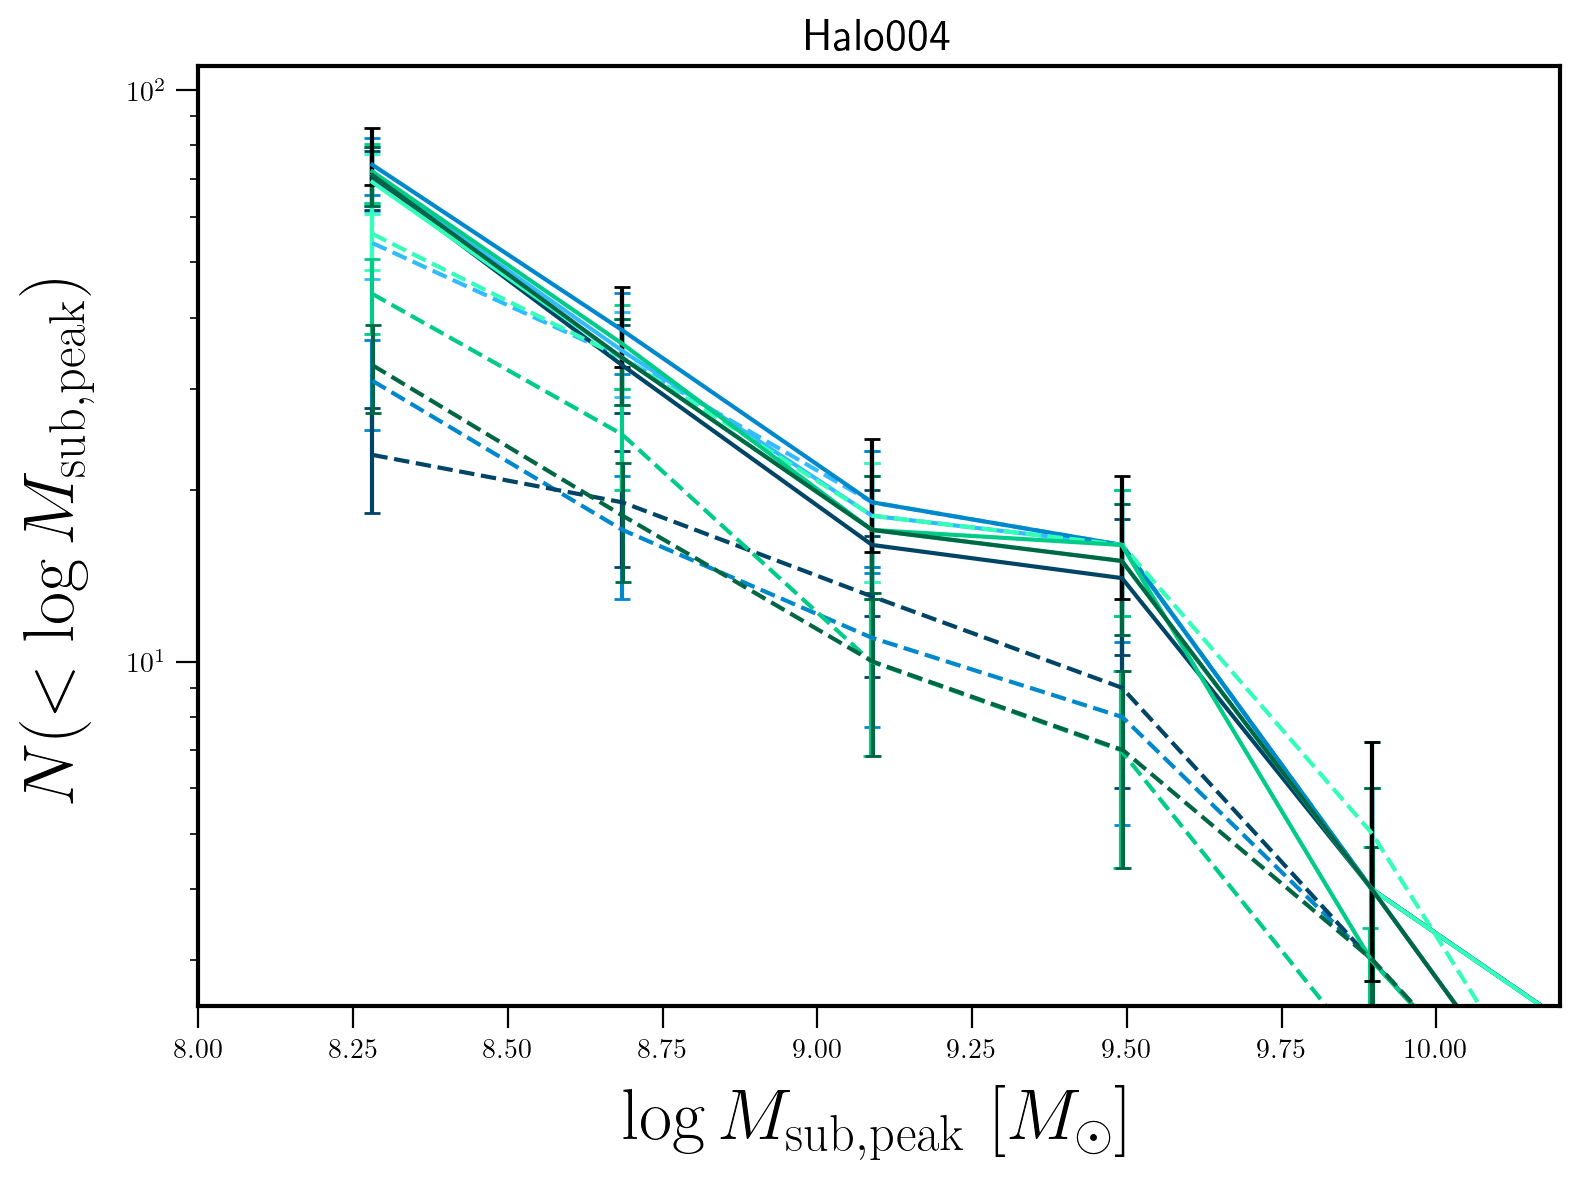

/tmp/ipykernel_3717670/904168356.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=4,fontsize=16,frameon=False,framealpha=1.0,ncol=2)


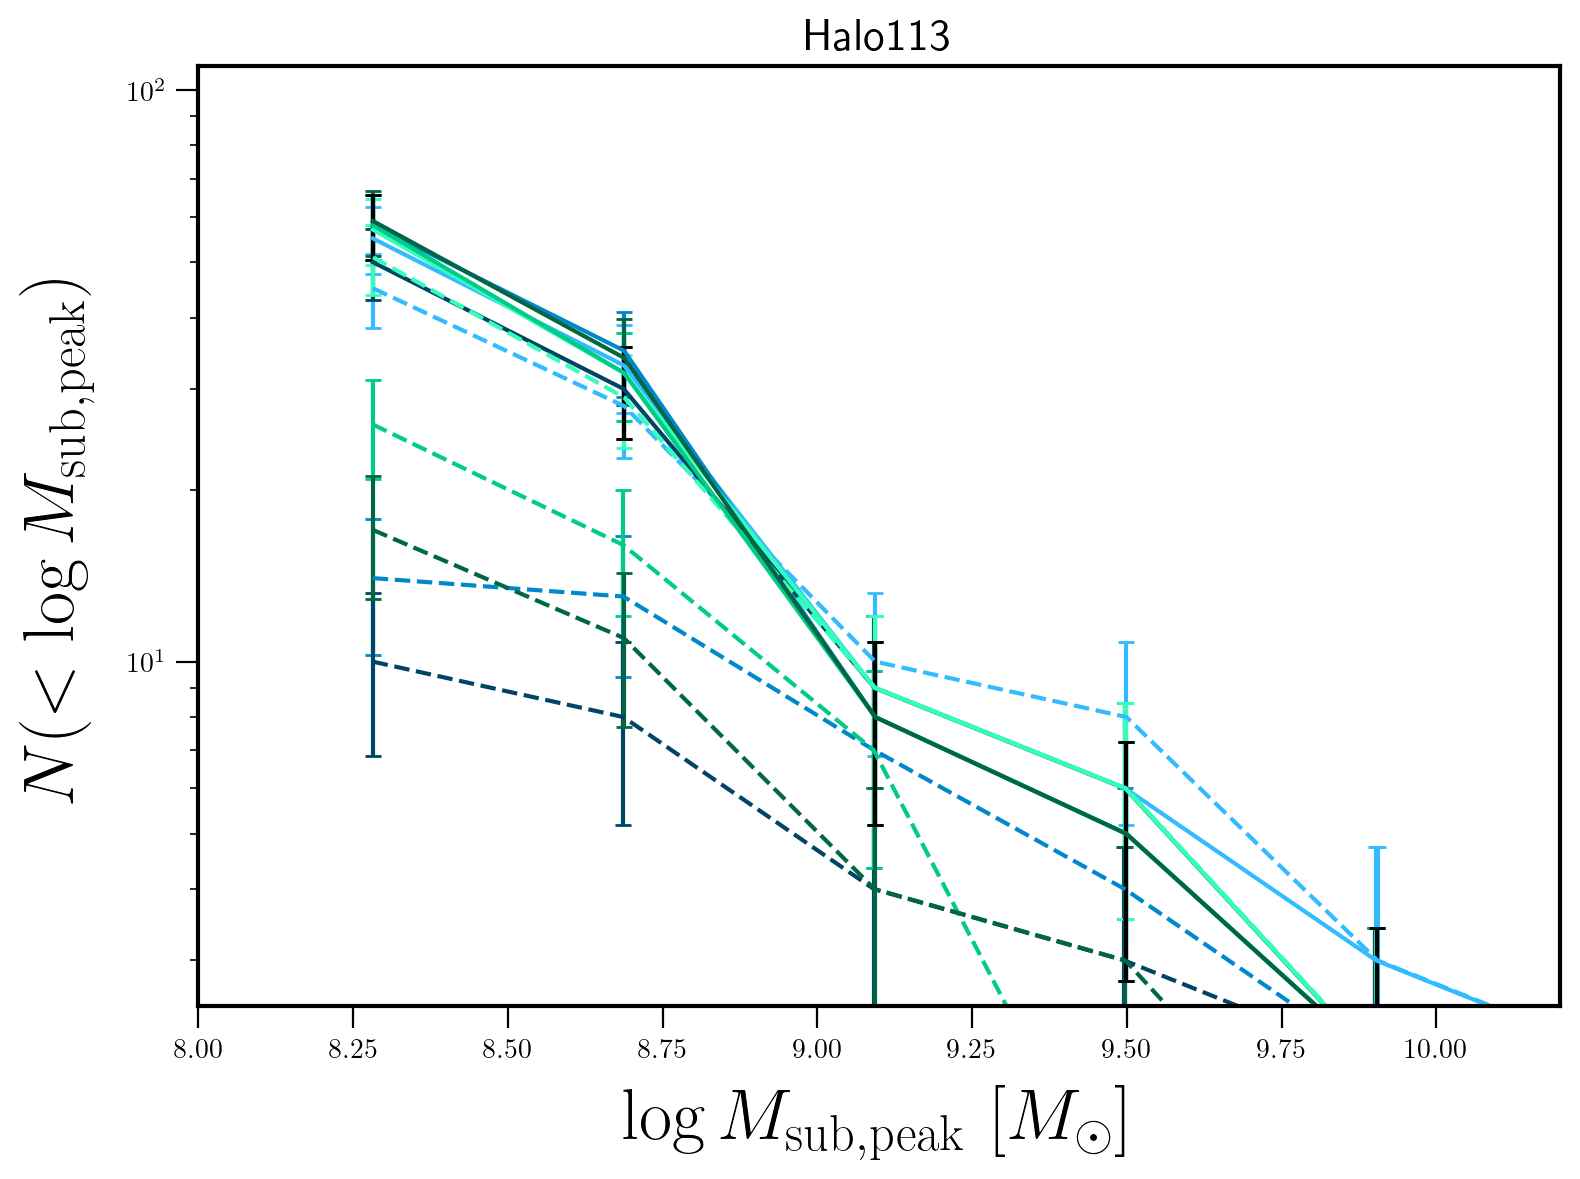

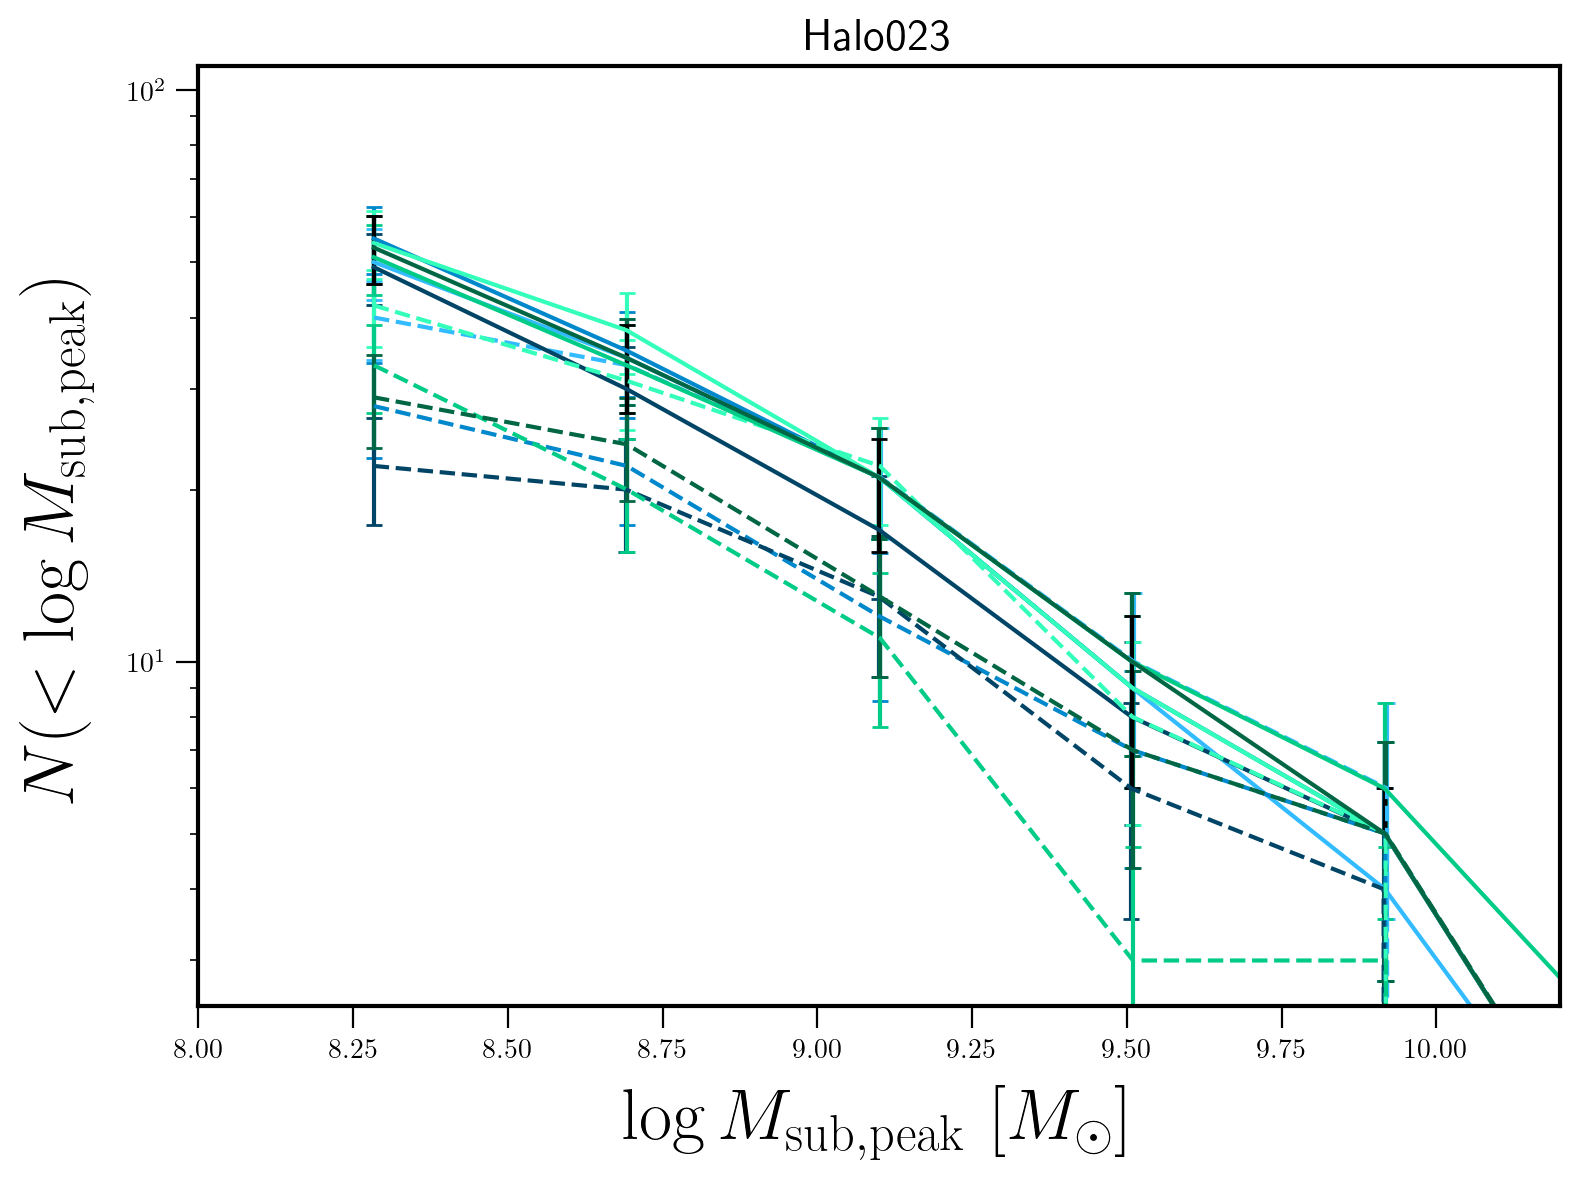

In [6]:
df_mcmc = pd.read_pickle('/central/groups/carnegie_poc/enadler/ncdm_resims/analysis/df_wdm.pkl')
base_mpeak = np.logspace(np.log10(3e5*300/0.7),np.log10(9e5*1.3e5/0.7),100)
x=0.5*(base_mpeak[1:]+base_mpeak[:-1])

labels_idm = {'1e-4GeV': r'$m_{\mathrm{IDM}}=10^{-4}~\mathrm{GeV}$',
             '1e-2GeV': r'$m_{\mathrm{IDM}}=10^{-2}~\mathrm{GeV}$',
             '1GeV': r'$m_{\mathrm{IDM}}=10^{0}~\mathrm{GeV}$'}

linestyles = {'halfmode': '-', 'envelope': '--'}

sim_all = {}
sim_all_diff = {}
pred_all = {}
pred_all_diff = {}
for model in models:
    if model != 'cdm':
        sim_all[model] = {}
        pred_all[model] = {}
        sim_all_diff[model] = {}
        pred_all_diff[model] = {}
        for method in methods:
            sim_all[model][method] = []
            pred_all[model][method] = []
            sim_all_diff[model][method] = []
            pred_all_diff[model][method] = []
    else:
        sim_all[model] = []
        pred_all[model] = []
        sim_all_diff[model] = []
        pred_all_diff[model] = []
    
for i,num in enumerate(halo_nums):
    ncdm_all = []
    plt.figure(figsize=(8,6))
    plt.yscale('log')
    for j,model in enumerate(models):
        if model != 'cdm':
            for k,method in enumerate(methods):
                ind = sim_data[num][model][method][2]['Mvir']/0.7 > 1.2e8
                x2 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][method][0]['mvir'][0]/(2.*0.7)),10)
                x2 = np.log10(x2)
                y = np.histogram(np.log10(sim_data[num][model][method][2]['Mpeak'][ind]/0.7),bins=x2,density=False)
                tot = np.cumsum(y[0])
                HMF = tot[-1]-tot
                sim_all[model][method].append(tot[-1]-tot)
                sim_all_diff[model][method].append(y[0])
                
                plt.errorbar(0.5*(x2[:-1]+x2[1:]),HMF,yerr=np.sqrt(HMF),
                                     markersize=5,capsize=3,color=sim_colors[model],ls=linestyles[method])
        else:
            ind = sim_data[num][model][2]['Mvir']/0.7 > 1.2e8
            x2 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
            x2 = np.log10(x2)
            y = np.histogram(np.log10(sim_data[num][model][2]['Mpeak'][ind]/0.7),bins=x2,density=False)
            tot = np.cumsum(y[0])
            HMF = tot[-1]-tot
            sim_all[model].append(tot[-1]-tot)
            sim_all_diff[model].append(y[0])
            
            plt.errorbar(0.5*(x2[:-1]+x2[1:]),HMF,yerr=np.sqrt(HMF),
                                 linestyle='none',markersize=5,capsize=3,color=sim_colors[model])
            
    plt.xlim(8,10.2)
    plt.ylim(2.5,110)

    plt.legend(loc=4,fontsize=16,frameon=False,framealpha=1.0,ncol=2)
    plt.xlabel(r'$\log M_{\rm{sub,peak}}\ [M_{\mathrm{\odot}}]$',fontsize=26,labelpad=8)
    plt.ylabel(r'$N(<\log M_{\mathrm{sub,peak}})$', fontsize=26, labelpad=12)
    plt.title(num,fontsize=16)
    
    plt.tight_layout()
    plt.show()

In [7]:
with open("pred_all_diff.bin", "rb") as output:
    pred_all_diff = pickle.load(output)

with open("sim_all_diff.bin", "rb") as output:
    sim_all_diff_wdm = pickle.load(output)

EOFError: Ran out of input

In [20]:
labels = {'wdm_3': r'$m_{\mathrm{WDM}}=3~\mathrm{keV}$', 'wdm_4': r'$m_{\mathrm{WDM}}=4~\mathrm{keV}$',
          'wdm_5': r'$m_{\mathrm{WDM}}=5~\mathrm{keV}$', 'wdm_6': r'$m_{\mathrm{WDM}}=6~\mathrm{keV}$',
          'wdm_6.5': r'$m_{\mathrm{WDM}}=6.5~\mathrm{keV}$', 'wdm_10': r'$m_{\mathrm{WDM}}=10~\mathrm{keV}$',
         'cdm':r'$\mathrm{CDM}$'}

labels_idm = {'idm_n2_1e-4GeV': r'$m_{\mathrm{IDM}}=10^{-4}~\mathrm{GeV}$',
 'idm_n2_1e-2GeV':r'$m_{\mathrm{IDM}}=10^{-2}~\mathrm{GeV}$',
 'idm_n2_1GeV':r'$m_{\mathrm{IDM}}=1~\mathrm{GeV}$',
 'idm_1e-4GeV':r'$m_{\mathrm{IDM}}=10^{-4}~\mathrm{GeV}$',
 'idm_1e-2GeV':r'$m_{\mathrm{IDM}}=10^{-2}~\mathrm{GeV}$',
 'idm_1GeV':r'$m_{\mathrm{IDM}}=1~\mathrm{GeV}$',
 'cdm': r'$\mathrm{CDM}$'}

KeyError: 'wdm_6.5'

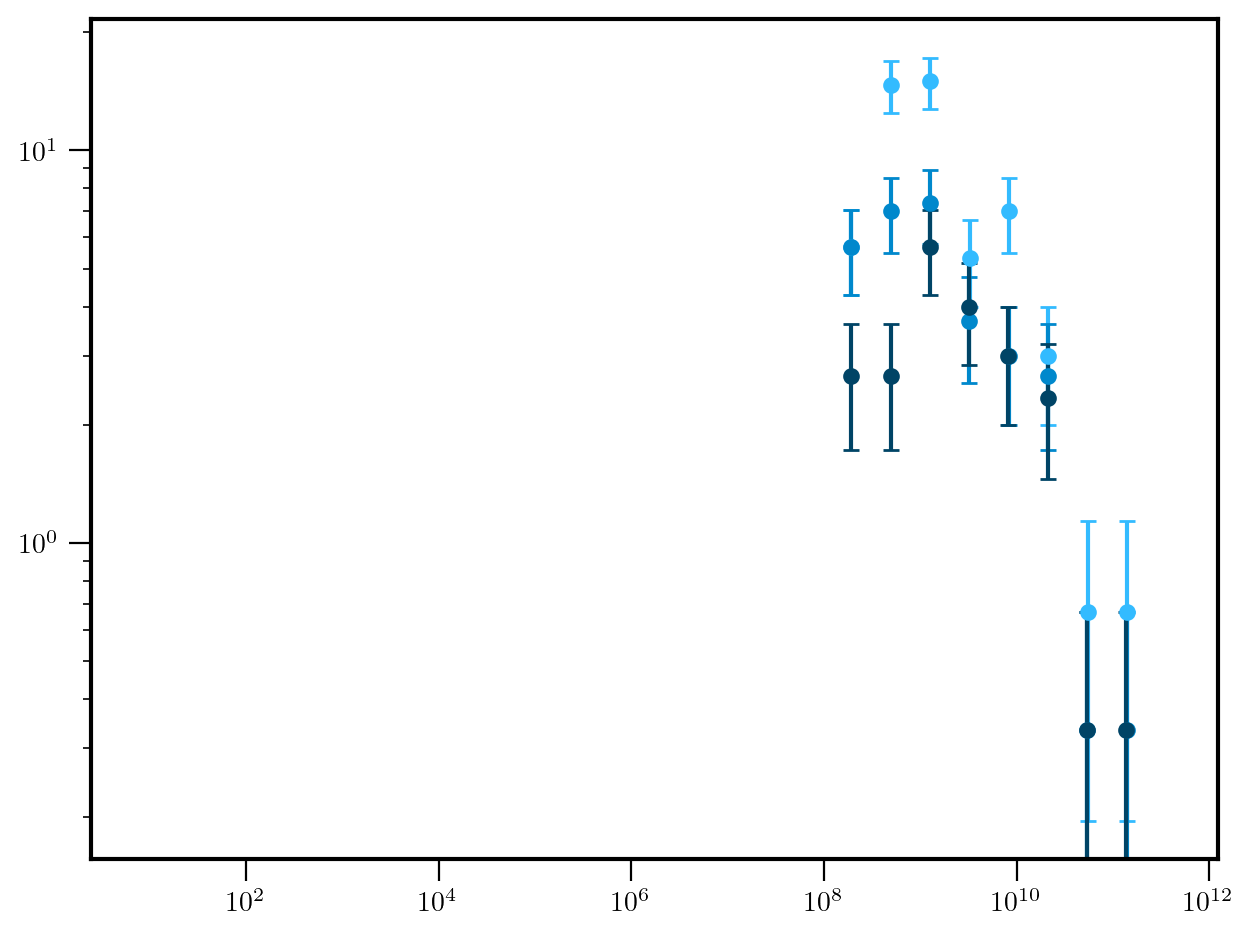

In [21]:
fig = plt.figure(figsize=(16,12))
                 
ax = fig.add_subplot(221)

ax.set_xscale('log')
ax.set_yscale('log')

idms = []
for model in models:
    if model == 'cdm':
        continue
    if 'n2' in model:
        for method in ['envelope']:
            x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][method][0]['mvir'][0]/(2.*0.7)),10)
            x3 = np.log10(x3)
            idms.append(ax.errorbar(10.**(0.5*(x3[:-1]+x3[1:])),np.mean(sim_all_diff[model][method],axis=0),
                         yerr=np.sqrt(np.mean(sim_all_diff[model][method],axis=0))/np.sqrt(3.),
                                     linestyle='none',markersize=5,marker='o',capsize=3,color=sim_colors[model],
                        label=labels_idm[model]))
        
wdms = []
for model in ['wdm_6.5','wdm_3']:
    if model == 'cdm':
        continue
    x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
    x3 = np.log10(x3)
    wdms.append(ax.plot(10.**x3,np.diff(x3)[0]*np.mean(pred_all_diff[model],axis=0),c=sim_colors[model],label=labels[model]))
    
    ax.fill_between(10.**x3,np.diff(x3)[0]*np.percentile(pred_all_diff[model],16,axis=0),
                     np.diff(x3)[0]*np.percentile(pred_all_diff[model],84,axis=0),
                        alpha=0.15,facecolor=sim_colors[model])

    ax.fill_between(10.**x3,np.diff(x3)[0]*np.percentile(pred_all_diff[model],2.5,axis=0),
                     np.diff(x3)[0]*np.percentile(pred_all_diff[model],97.5,axis=0),
                        alpha=0.15,facecolor=sim_colors[model])
                
    x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
    x3 = np.log10(x3)
    
    
first_legend = plt.legend(handles=[idms[0],idms[1],idms[2]], loc=1, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[wdms[0][0],wdms[1][0]], loc='lower center', fontsize=16,frameon=False,framealpha=1.0,ncol=2)

ax.set_xlim(1e8,10**(10.5))
ax.set_ylim(1,40)

ax.set_xticks([1e8,1e9,1e10])
ax.set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$'],fontsize=20)
ax.set_yticks([1e0,1e1])
ax.set_yticklabels([r'$10^0$',r'$10^1$'],fontsize=20)
ax.text(10.**9.65,13.2,r'$n=2,\ \mathrm{envelope}$',fontsize=20)
ax.set_xlabel(r'$M_{\rm{sub,peak}}\ [M_{\mathrm{\odot}}]$',fontsize=26,labelpad=8)
ax.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\mathrm{sub,peak}}$', fontsize=26, labelpad=12)
                 
###

ax = fig.add_subplot(222)

ax.set_xscale('log')
ax.set_yscale('log')

idms = []
for model in models:
    if model == 'cdm':
        continue
    if 'n2' in model:
        for method in ['halfmode']:
            x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][method][0]['mvir'][0]/(2.*0.7)),10)
            x3 = np.log10(x3)
            idms.append(ax.errorbar(10.**(0.5*(x3[:-1]+x3[1:])),np.mean(sim_all_diff[model][method],axis=0),
                         yerr=np.sqrt(np.mean(sim_all_diff[model][method],axis=0))/np.sqrt(3.),
                                     linestyle='none',markersize=5,marker='o',capsize=3,color=sim_colors[model],
                        label=labels_idm[model]))
        
wdms = []
for model in ['wdm_6.5','wdm_3']:
    if model == 'cdm':
        continue
    x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
    x3 = np.log10(x3)
    wdms.append(ax.plot(10.**x3,np.diff(x3)[0]*np.mean(pred_all_diff[model],axis=0),c=sim_colors[model],label=labels[model]))
    
    ax.fill_between(10.**x3,np.diff(x3)[0]*np.percentile(pred_all_diff[model],16,axis=0),
                     np.diff(x3)[0]*np.percentile(pred_all_diff[model],84,axis=0),
                        alpha=0.15,facecolor=sim_colors[model])

    ax.fill_between(10.**x3,np.diff(x3)[0]*np.percentile(pred_all_diff[model],2.5,axis=0),
                     np.diff(x3)[0]*np.percentile(pred_all_diff[model],97.5,axis=0),
                        alpha=0.15,facecolor=sim_colors[model])
                
    x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
    x3 = np.log10(x3)
    
    
first_legend = plt.legend(handles=[idms[0],idms[1],idms[2]], loc=1, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
# plt.legend(handles=[wdms[0][0],wdms[1][0]], loc='lower center', fontsize=16,frameon=False,framealpha=1.0,ncol=2)

ax.set_xlim(1e8,10**(10.5))
ax.set_ylim(1,40)

ax.set_xticks([1e8,1e9,1e10])
ax.set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$'],fontsize=20)
ax.set_yticks([1e0,1e1])
ax.set_yticklabels([r'$10^0$',r'$10^1$'],fontsize=20)
ax.text(10.**9.65,13.2,r'$n=2,\ \mathrm{half}$-$\mathrm{mode}$',fontsize=20)
ax.set_xlabel(r'$M_{\rm{sub,peak}}\ [M_{\mathrm{\odot}}]$',fontsize=26,labelpad=8)
ax.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\mathrm{sub,peak}}$', fontsize=26, labelpad=12)
                 
###
                 
ax = fig.add_subplot(223)

ax.set_xscale('log')
ax.set_yscale('log')

idms = []
for model in models:
    if model == 'cdm':
        continue
    if 'n2' in model:
        continue
    for method in ['envelope']:
        x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][method][0]['mvir'][0]/(2.*0.7)),10)
        x3 = np.log10(x3)
        idms.append(ax.errorbar(10.**(0.5*(x3[:-1]+x3[1:])),np.mean(sim_all_diff[model][method],axis=0),
                     yerr=np.sqrt(np.mean(sim_all_diff[model][method],axis=0))/np.sqrt(3.),
                                 linestyle='none',markersize=5,marker='o',capsize=3,color=sim_colors[model],
                    label=labels_idm[model]))
        
wdms = []
for model in ['wdm_6.5','wdm_3']:
    if model == 'cdm':
        continue
    x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
    x3 = np.log10(x3)
    wdms.append(ax.plot(10.**x3,np.diff(x3)[0]*np.mean(pred_all_diff[model],axis=0),c=sim_colors[model],label=labels[model]))
    
    ax.fill_between(10.**x3,np.diff(x3)[0]*np.percentile(pred_all_diff[model],16,axis=0),
                     np.diff(x3)[0]*np.percentile(pred_all_diff[model],84,axis=0),
                        alpha=0.15,facecolor=sim_colors[model])

    ax.fill_between(10.**x3,np.diff(x3)[0]*np.percentile(pred_all_diff[model],2.5,axis=0),
                     np.diff(x3)[0]*np.percentile(pred_all_diff[model],97.5,axis=0),
                        alpha=0.15,facecolor=sim_colors[model])
                
    x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
    x3 = np.log10(x3)
    
    
first_legend = plt.legend(handles=[idms[0],idms[1],idms[2]], loc=1, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
# plt.legend(handles=[wdms[0][0],wdms[1][0]], loc='lower center', fontsize=16,frameon=False,framealpha=1.0,ncol=2)

ax.set_xlim(1e8,10**(10.5))
ax.set_ylim(1,40)

ax.set_xticks([1e8,1e9,1e10])
ax.set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$'],fontsize=20)
ax.set_yticks([1e0,1e1])
ax.set_yticklabels([r'$10^0$',r'$10^1$'],fontsize=20)
ax.text(10.**9.65,13.2,r'$n=4,\ \mathrm{envelope}$',fontsize=20)
ax.set_xlabel(r'$M_{\rm{sub,peak}}\ [M_{\mathrm{\odot}}]$',fontsize=26,labelpad=8)
ax.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\mathrm{sub,peak}}$', fontsize=26, labelpad=12)
                 
###
                 
ax = fig.add_subplot(224)

ax.set_xscale('log')
ax.set_yscale('log')

idms = []
for model in models:
    if model == 'cdm':
        continue
    if 'n2' in model:
        continue
    for method in ['halfmode']:
        x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][method][0]['mvir'][0]/(2.*0.7)),10)
        x3 = np.log10(x3)
        idms.append(ax.errorbar(10.**(0.5*(x3[:-1]+x3[1:])),np.mean(sim_all_diff[model][method],axis=0),
                     yerr=np.sqrt(np.mean(sim_all_diff[model][method],axis=0))/np.sqrt(3.),
                                 linestyle='none',markersize=5,marker='o',capsize=3,color=sim_colors[model],
                    label=labels_idm[model]))
        
wdms = []
for model in ['wdm_6.5','wdm_3']:
    if model == 'cdm':
        continue
    x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
    x3 = np.log10(x3)
    wdms.append(ax.plot(10.**x3,np.diff(x3)[0]*np.mean(pred_all_diff[model],axis=0),c=sim_colors[model],label=labels[model]))
    
    ax.fill_between(10.**x3,np.diff(x3)[0]*np.percentile(pred_all_diff[model],16,axis=0),
                     np.diff(x3)[0]*np.percentile(pred_all_diff[model],84,axis=0),
                        alpha=0.15,facecolor=sim_colors[model])

    ax.fill_between(10.**x3,np.diff(x3)[0]*np.percentile(pred_all_diff[model],2.5,axis=0),
                     np.diff(x3)[0]*np.percentile(pred_all_diff[model],97.5,axis=0),
                        alpha=0.15,facecolor=sim_colors[model])
                
    x3 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
    x3 = np.log10(x3)
    
    
first_legend = plt.legend(handles=[idms[0],idms[1],idms[2]], loc=1, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
# plt.legend(handles=[wdms[0][0],wdms[1][0]], loc='lower center', fontsize=16,frameon=False,framealpha=1.0,ncol=2)

ax.set_xlim(1e8,10**(10.5))
ax.set_ylim(1,40)

ax.set_xticks([1e8,1e9,1e10])
ax.set_xticklabels([r'$10^8$',r'$10^9$',r'$10^{10}$'],fontsize=20)
ax.set_yticks([1e0,1e1])
ax.set_yticklabels([r'$10^0$',r'$10^1$'],fontsize=20)
ax.text(10.**9.65,13.2,r'$n=4,\ \mathrm{half}$-$\mathrm{mode}$',fontsize=20)
ax.set_xlabel(r'$M_{\rm{sub,peak}}\ [M_{\mathrm{\odot}}]$',fontsize=26,labelpad=8)
ax.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\mathrm{sub,peak}}$', fontsize=26, labelpad=12)
                 
###

plt.tight_layout()
plt.subplots_adjust(wspace = 0.2)
#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/shmf_all_matched.pdf')

### Transfers

In [ ]:
import colossus
from colossus.halo import profile_nfw
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 70.0, 'Om0': 0.286, 'Ob0': 0.049, 'sigma8': 0.82, 'ns': 0.96}
cosmology.addCosmology('myCosmo', **params)
cosmo = cosmology.setCosmology('myCosmo')

h = 0.7
Omega_m = 0.286
rho_m = cosmo.rho_m(0.)*1e9*(0.7**2) #Msun/Mpc^3

def M_k(k):
    return 4*np.pi*rho_m*((np.pi/k)**3)/3.

def k_M(M):
    return (3.*M/(4*np.pi*rho_m))**(-1./3.)*np.pi

from scipy.interpolate import griddata

BASE_PATH = '/home/arifchu/class_public-master-new-dmeff/pks/'
BASE_PATH_ALT = '/central/groups/carnegie_poc/enadler/ncdm_resims/Halo004/running_v1/'

cdm = np.loadtxt(BASE_PATH+'lcdm_pk.dat')
cdm_z99 = np.loadtxt('/home/arifchu/class_public-master-new-dmeff/lcdm_class_z99_sync_pk.dat')

wdm_transfers = {}
cdm_transfers_wdm = {}
for mass in ['3', '3.5', '4', '5', '6','6.5', '10']:
    #if mass in ['6','6.5']:
    wdm_transfers[mass] = np.loadtxt(BASE_PATH+'wdm_{}KeV_pk.dat'.format(mass))
    #else:
        #wdm_transfers[mass] = np.loadtxt(BASE_PATH+'wdm_{}kev_pk.dat'.format(mass))
    cdm_transfers_wdm[mass] = griddata(cdm[:,0], cdm[:,1], wdm_transfers[mass][:,0], method='cubic')
        
fdm_transfers = {}
cdm_transfers_fdm = {}
for mass in ['25.9', '69.4', '113', '151', '185', '490']:
    fdm_transfers[mass] = np.loadtxt(BASE_PATH+'fdm_{}e-22eV_pk.dat'.format(mass))
    cdm_transfers_fdm[mass] = griddata(cdm[:,0], cdm_z99[:,1], fdm_transfers[mass][:,0], method='cubic')
        
idm_transfers = {}
cdm_transfers_idm = {}
for n in ['2','4']:
    idm_transfers[n] = {}
    cdm_transfers_idm[n] = {}
    for mass in ['1e-4GeV', '1e-2GeV', '1GeV']:
        idm_transfers[n][mass] = {}
        cdm_transfers_idm[n][mass] = {}
        for method in ['halfmode', 'envelope']:
            if n == '2':
                idm_transfers[n][mass][method] = np.loadtxt(BASE_PATH+'idm_n{}_{}_{}_z0_Pk.dat'.format(n,mass,method))
            else:
                idm_transfers[n][mass][method] = np.loadtxt(BASE_PATH+'idm_{}_{}_pk.dat'.format(mass,method))
            cdm_transfers_idm[n][mass][method] = griddata(cdm[:,0], cdm[:,1], 
                                                      idm_transfers[n][mass][method][:,0], method='cubic')

In [ ]:
omega_mh2 = 0.11711; h = 0.7
a = 0.0437; b = -1.188; nu = 1.049; theta = 2.012; eta = 0.2463

def transfer(k,mwdm):
    alpha = a*(mwdm**b)*((omega_mh2/0.12)**eta)*((h/0.6736)**theta)
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

In [22]:
masses_halfmode = {}
masses_envelope = {}

for model in models:
    if model == 'cdm':
        continue
    for method in methods:
        counts = {}
        idm_num = 0
        print(model,method)
        for num in halo_nums:
            counts[num] = []
            cdm_mpeaks = sim_data[num]['cdm'][2][sim_data[num]['cdm'][2]['Mvir']/0.7>1.2e8]['Mpeak']/0.7
            idm_num += len(sim_data[num][model][method][2][sim_data[num][model][method][2]['Mvir']/0.7>1.2e8])
            for mwdm in np.linspace(2,15,10000):
                weights = (1.+(2.5*Mhm(mwdm)/cdm_mpeaks)**0.9)**(-1.*1.0)
                counts[num].append(np.sum(weights))
        counts = np.array(counts['Halo004'])+np.array(counts['Halo113'])+np.array(counts['Halo023'])
        print(idm_num,np.array(counts)[np.argmin(np.abs(np.array(counts)-idm_num))],
              np.linspace(2,15,10000)[np.argmin(np.abs(np.array(counts)-idm_num))])
        if method == 'halfmode':
            masses_halfmode[model] = np.linspace(2,15,10000)[np.argmin(np.abs(np.array(counts)-idm_num))]
        else:
            masses_envelope[model] = np.linspace(2,15,10000)[np.argmin(np.abs(np.array(counts)-idm_num))]

idm_n2_1e-4GeV halfmode
218 218.00276 7.477447744774477
idm_n2_1e-4GeV envelope
156 156.01688 4.138713871387139
idm_n2_1e-2GeV halfmode
231 231.00092 10.401440144014401
idm_n2_1e-2GeV envelope
90 89.982864 2.668266826682668
idm_n2_1GeV halfmode
210 209.99956 6.636263626362636
idm_n2_1GeV envelope
63 62.96625 2.156015601560156
idm_1e-4GeV halfmode
219 218.99728 7.608760876087609
idm_1e-4GeV envelope
168 167.99655 4.501450145014502
idm_1e-2GeV halfmode
228 228.00081 9.356135613561356
idm_1e-2GeV envelope
129 129.0121 3.465246524652465
idm_1GeV halfmode
229 228.99884 9.659065906590659
idm_1GeV envelope
99 98.9989 2.8424842484248423


NameError: name 'wdm_transfers' is not defined

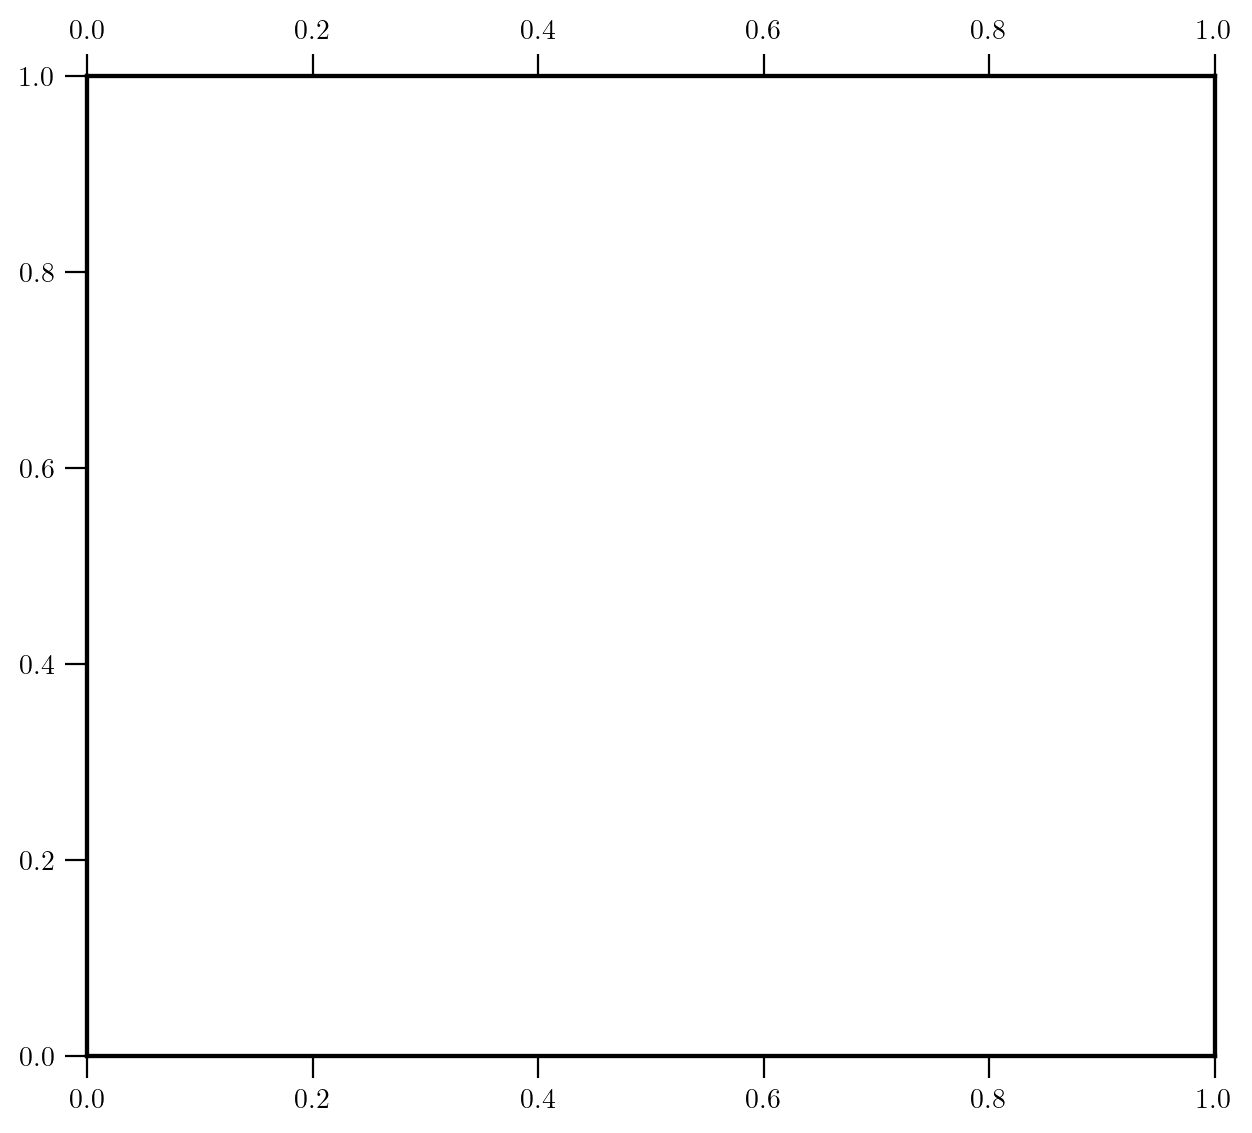

In [23]:
fig = plt.figure(figsize=(16,14))
                 
ax = fig.add_subplot(221)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)

kvec = np.logspace(0, np.log10(500), 1000)
for model in models:
    if model == 'cdm':
        continue
    if 'n2' in model:
        ax.plot(kvec*0.7, transfer(kvec, masses_envelope[model])**2, color=sim_colors[model],linestyle='--')

halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{Matched\ WDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{IDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m4 = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m2 = ax.semilogx(idm_transfers['2']['1e-2GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1e-2GeV'],label=r'$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m0 = ax.semilogx(idm_transfers['2']['1GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1GeV'],label=r'$m_{\mathrm{DM}}=1\ \mathrm{GeV}$')#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[envelope[0],halfmode[0]], loc=1, fontsize=16, frameon=False, bbox_to_anchor = (1.0,0.95))
ax.text(1.2,0.335,r'$n=2,\ \mathrm{envelope}$',fontsize=20)
                 
###

ax = fig.add_subplot(222)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)

kvec = np.logspace(0, np.log10(500), 1000)
for model in models:
    if model == 'cdm':
        continue
    if 'n2' in model:
        ax.plot(kvec*0.7, transfer(kvec, masses_halfmode[model])**2, color=sim_colors[model],linestyle='--')

halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{Matched\ WDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{IDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

    
m4 = ax.semilogx(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')

ax.semilogx(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{half}$-$\mathrm{mode}$')

m2 = ax.semilogx(idm_transfers['2']['1e-2GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')

m0 = ax.semilogx(idm_transfers['2']['1GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1GeV'],label='$m_{\mathrm{DM}}=1\ \mathrm{GeV}$')

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[envelope[0],halfmode[0]], loc=2, fontsize=16, frameon=False, bbox_to_anchor = (0.0,0.95))
ax.text(1.2,0.335,r'$n=2,\ \mathrm{half}$-$\mathrm{mode}$',fontsize=20)
                 
###
                 
ax = fig.add_subplot(223)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)

kvec = np.logspace(0, np.log10(500), 1000)
for model in models:
    if model == 'cdm':
        continue
    elif 'n2' in model:
        continue
    else:
        ax.plot(kvec*0.7, transfer(kvec, masses_envelope[model])**2, color=sim_colors[model],linestyle='--')
    
halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_1e-4GeV'],label='$\mathrm{Matched\ WDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1e-4GeV'],label='$\mathrm{IDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m4 = ax.semilogx(idm_transfers['4']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m2 = ax.semilogx(idm_transfers['4']['1e-2GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

m0 = ax.semilogx(idm_transfers['4']['1GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1GeV'],label='$m_{\mathrm{DM}}=1\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[envelope[0],halfmode[0]], loc=1, fontsize=16, frameon=False, bbox_to_anchor = (1.0,0.95))
ax.text(1.2,0.335,r'$n=4,\ \mathrm{envelope}$',fontsize=20)
                 
###
                 
ax = fig.add_subplot(224)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)

halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_1e-4GeV'],label='$\mathrm{Matched\ WDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1e-4GeV'],label='$\mathrm{IDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

kvec = np.logspace(0, np.log10(500), 1000)
for model in models:
    if model == 'cdm':
        continue
    elif 'n2' in model:
        continue
    else:
        ax.plot(kvec*0.7, transfer(kvec, masses_halfmode[model])**2, color=sim_colors[model],linestyle='--')
    
m4 = ax.semilogx(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')

m2 = ax.semilogx(idm_transfers['4']['1e-2GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode']),
             lw=2,c=sim_colors['idm_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')

m0 = ax.semilogx(idm_transfers['4']['1GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode']),
             lw=2,c=sim_colors['idm_1GeV'],label='$m_{\mathrm{DM}}=1\ \mathrm{GeV}$')

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[envelope[0],halfmode[0]], loc=2, fontsize=16, frameon=False, bbox_to_anchor = (0.0,0.95))
ax.text(1.2,0.335,r'$n=4,\ \mathrm{half}$-$\mathrm{mode}$',fontsize=20)
                 
###

plt.tight_layout()
plt.subplots_adjust(wspace = 0.2,hspace=0.375)
#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_all_matched.pdf')

### Limit Plot

In [6]:
cs = pd.read_csv('CrossSections.csv',header=None,skiprows=1)

In [7]:
cs

,0,1,2,3,4,5,6
0,n=4,1e-4 GeV,1e-2 GeV,1 GeV,1e-4 GeV,1e-2 GeV,1 GeV
1,3keV,2.00E-25,4.10E-21,2.10E-17,2.00E-23,3.40E-18,6.60E-15
2,3.5keV,9.14E-26,2.20E-21,1.12E-17,8.60E-24,1.80E-18,3.66E-15
3,4keV,4.80E-26,1.30E-21,6.40E-18,1.80E-24,9.90E-19,1.80E-15
4,4.5keV,2.35E-26,8.01E-22,3.94E-18,9.10E-25,6.50E-19,1.30E-15
5,5keV,1.30E-26,5.20E-22,2.60E-18,5.80E-25,4.40E-19,7.10E-16
6,5.5keV,7.32E-27,3.27E-22,1.70E-18,4.20E-25,3.20E-19,5.50E-16
7,6keV,4.20E-27,2.40E-22,1.20E-18,1.80E-25,2.20E-19,3.10E-16
8,6.5keV,2.20E-27,1.70E-22,8.60E-19,3.40E-26,1.70E-19,2.80E-16
9,7keV,1.30E-27,1.23E-22,6.20E-19,2.80E-26,1.25E-19,2.10E-16


In [8]:
wdms = [3,3.5,4,4.5,5,5.5,6,6.5,7,8,9,10]
masses = [1e-4,1e-2,1]
mass_labels = ['1e-4','1e-2','1']

cs_values_halfmode_n4 = {}
cs_values_envelope_n4 = {}
for j,mass in enumerate(masses):
    cs_values_halfmode_n4[mass] = []
    cs_values_envelope_n4[mass] = []
    for i,wdm in enumerate(wdms):
        cs_values_halfmode_n4[mass].append(float(cs[j+1][i+1]))
        cs_values_envelope_n4[mass].append(float(cs[j+4][i+1]))

cs_values_halfmode_n2 = {}
cs_values_envelope_n2 = {}
for j,mass in enumerate(masses):
    cs_values_halfmode_n2[mass] = []
    cs_values_envelope_n2[mass] = []
    for i,wdm in enumerate(wdms):
        cs_values_halfmode_n2[mass].append(float(cs[j+1][i+15]))
        cs_values_envelope_n2[mass].append(float(cs[j+4][i+15]))

--- idm_1e-4GeV ---
Half mode Star (x, y): (7.61 keV, 1.3000e-26 cm^2)
Envelope Star (x, y):  (4.50 keV, 5.8000e-25 cm^2)
Intersection at 5.9 keV: 1.0496e-25 cm^2

--- idm_1e-2GeV ---
Half mode Star (x, y): (9.36 keV, 5.2000e-22 cm^2)
Envelope Star (x, y):  (3.47 keV, 4.4000e-19 cm^2)
Intersection at 5.9 keV: 2.7134e-20 cm^2

--- idm_1GeV ---
Half mode Star (x, y): (9.66 keV, 2.6000e-18 cm^2)
Envelope Star (x, y):  (2.84 keV, 7.1000e-16 cm^2)
Intersection at 5.9 keV: 5.7344e-17 cm^2



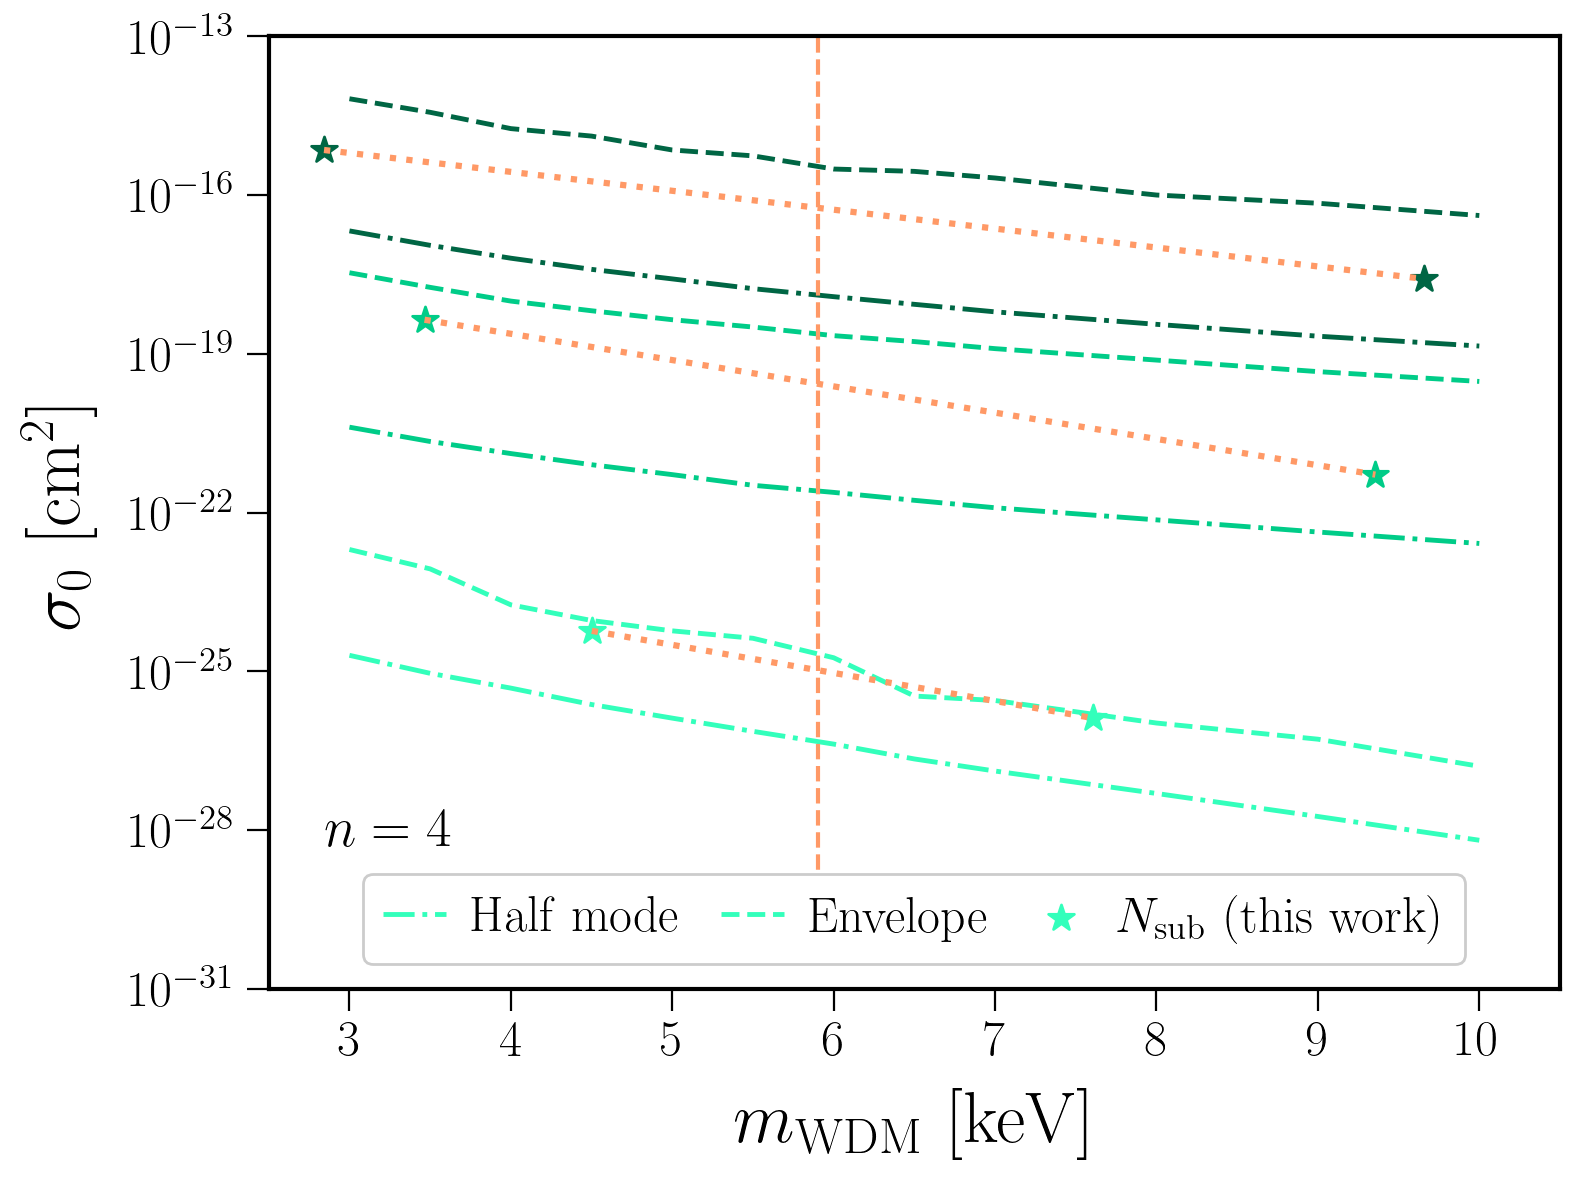

In [27]:
plt.figure(figsize=(8,6))

for i,mass in enumerate(cs_values_halfmode_n4.keys()):
    
    # --- Build the n=4 key (no 'n2') ---
    sim_key = 'idm_{}GeV'.format(mass_labels[i])
    
    # --- Add labels only on the first loop (i=0) to create the legend ---
    if i == 0:
        label_halfmode = r'$\mathrm{Half\ mode}$'
        label_envelope = r'$\mathrm{Envelope}$'
        label_nsub = r'$N_{\mathrm{sub}}\ (\mathrm{this\ work})$'
    else:
        label_halfmode, label_envelope, label_nsub = None, None, None
    # ---

    plt.semilogy(np.ravel(wdms),np.ravel(cs_values_halfmode_n4[mass]),
                 c=sim_colors[sim_key],ls='-.',lw=1.75, label=label_halfmode)
    
    plt.semilogy(np.ravel(wdms),np.ravel(cs_values_envelope_n4[mass]),ls='--',lw=1.75,
                 c=sim_colors[sim_key], label=label_envelope)

    plt.plot([masses_envelope[sim_key],
              masses_halfmode[sim_key]],
             [cs_values_envelope_n4[mass][4],cs_values_halfmode_n4[mass][4]],
             c=sim_colors['wdm_3'],ls=':',lw=2.25)
    
    plt.scatter(masses_halfmode[sim_key],cs_values_halfmode_n4[mass][4],
                marker='*',s=95,c=sim_colors[sim_key])
    
    # Add label to only one of the scatter plots to avoid duplicate legend entries
    plt.scatter(masses_envelope[sim_key],cs_values_envelope_n4[mass][4],
                marker='*',s=95,c=sim_colors[sim_key], label=label_nsub)

    
    ### --- Intersection and Star Position Calculation (n=4 case) ---
    
    # --- Star Positions ---
    # Get Half mode star position
    star_halfmode_x = masses_halfmode[sim_key]
    star_halfmode_y = cs_values_halfmode_n4[mass][4]
    
    # Get Envelope star position
    star_envelope_x = masses_envelope[sim_key]
    star_envelope_y = cs_values_envelope_n4[mass][4]

    print(f"--- {sim_key} ---")
    print(f"Half mode Star (x, y): ({star_halfmode_x:.2f} keV, {star_halfmode_y:.4e} cm^2)")
    print(f"Envelope Star (x, y):  ({star_envelope_x:.2f} keV, {star_envelope_y:.4e} cm^2)")

    # --- Intersection Calculation ---
    # Calculate log-space coordinates for interpolation
    y1_log = np.log10(star_halfmode_y)
    y2_log = np.log10(star_envelope_y)

    # Calculate the slope (m) and intercept (b) of the line
    m = (y2_log - y1_log) / (star_envelope_x - star_halfmode_x)
    b = y1_log - m * star_halfmode_x
    
    target_x = 5.9
    
    # Solve for the y-value (the cross-section) at that x
    log_y_intersect = m * target_x + b
    cross_section_at_intersect = 10.**(log_y_intersect)
    
    # Print the final result
    print(f"Intersection at {target_x} keV: {cross_section_at_intersect:.4e} cm^2\n")
    
    ### --- End of Calculation ---


plt.plot(np.ones(10)*5.9,np.linspace(10**-30,1e-13,10),ls='--',c=sim_colors['wdm_3'])

plt.xlim(2.5,10.5)
plt.ylim(10**-31,1e-13)

plt.xlabel(r'$m_{\mathrm{WDM}}~[\mathrm{keV}]$',fontsize=26,labelpad=8)
plt.ylabel(r'$\sigma_{0}~[\mathrm{cm}^2]$',fontsize=26,labelpad=12)

plt.xticks([3,4,5,6,7,8,9,10],fontsize=18)
plt.yticks([1e-31,1e-28,1e-25,1e-22,1e-19,1e-16,1e-13],fontsize=18)

plt.text(2.85,5e-29,r'$n=4$',fontsize=20)
plt.legend(loc='lower center',ncol=3,handlelength=1.25,columnspacing=0.8,handletextpad=0.5,
           framealpha=1,fontsize=18,frameon=True)

plt.tight_layout()
#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/idm_constraint_n4.pdf')
plt.show()

In [28]:
labels_idm['idm_n2_{}GeV'.format(mass_labels[i])]

'$m_{\\mathrm{IDM}}=1~\\mathrm{GeV}$'

In [29]:
labels_idm['idm_n2_{}GeV'.format(mass_labels[i])][0]+labels_idm['idm_n2_{}GeV'.format(mass_labels[i])][18:]

'$1~\\mathrm{GeV}$'

In [30]:
labels_idm['idm_n2_1e-4GeV'] = 'Your Label for n=2, 1e-4 GeV'

In [31]:
# Find this dictionary in your code and add the 3 n=2 keys:
labels_idm = {
    # ... your existing keys for n=4 ('idm_1e-4GeV', etc.) ...
    
    # --- Add these 3 lines ---
    'idm_n2_1e-4GeV': r'$m_X=10^{-4}\ \mathrm{GeV}$', 
    'idm_n2_1e-2GeV': r'$m_X=10^{-2}\ \mathrm{GeV}$',
    'idm_n2_1GeV': r'$m_X=1\ \mathrm{GeV}$'
}

In [32]:
print(masses_envelope)

{'idm_n2_1e-4GeV': 4.138713871387139, 'idm_n2_1e-2GeV': 2.668266826682668, 'idm_n2_1GeV': 2.156015601560156, 'idm_1e-4GeV': 4.501450145014502, 'idm_1e-2GeV': 3.465246524652465, 'idm_1GeV': 2.8424842484248423}


--- idm_n2_1e-4GeV ---
Half mode Star (x, y): (7.48 keV, 1.1000e-27 cm^2)
Envelope Star (x, y):  (4.14 keV, 8.6000e-27 cm^2)
Intersection at 5.9 keV: 2.9064e-27 cm^2

--- idm_n2_1e-2GeV ---
Half mode Star (x, y): (10.40 keV, 2.8000e-25 cm^2)
Envelope Star (x, y):  (2.67 keV, 1.3000e-23 cm^2)
Intersection at 5.9 keV: 2.6145e-24 cm^2

--- idm_n2_1GeV ---
Half mode Star (x, y): (6.64 keV, 3.6000e-23 cm^2)
Envelope Star (x, y):  (2.16 keV, 1.2000e-21 cm^2)
Intersection at 5.9 keV: 6.4057e-23 cm^2



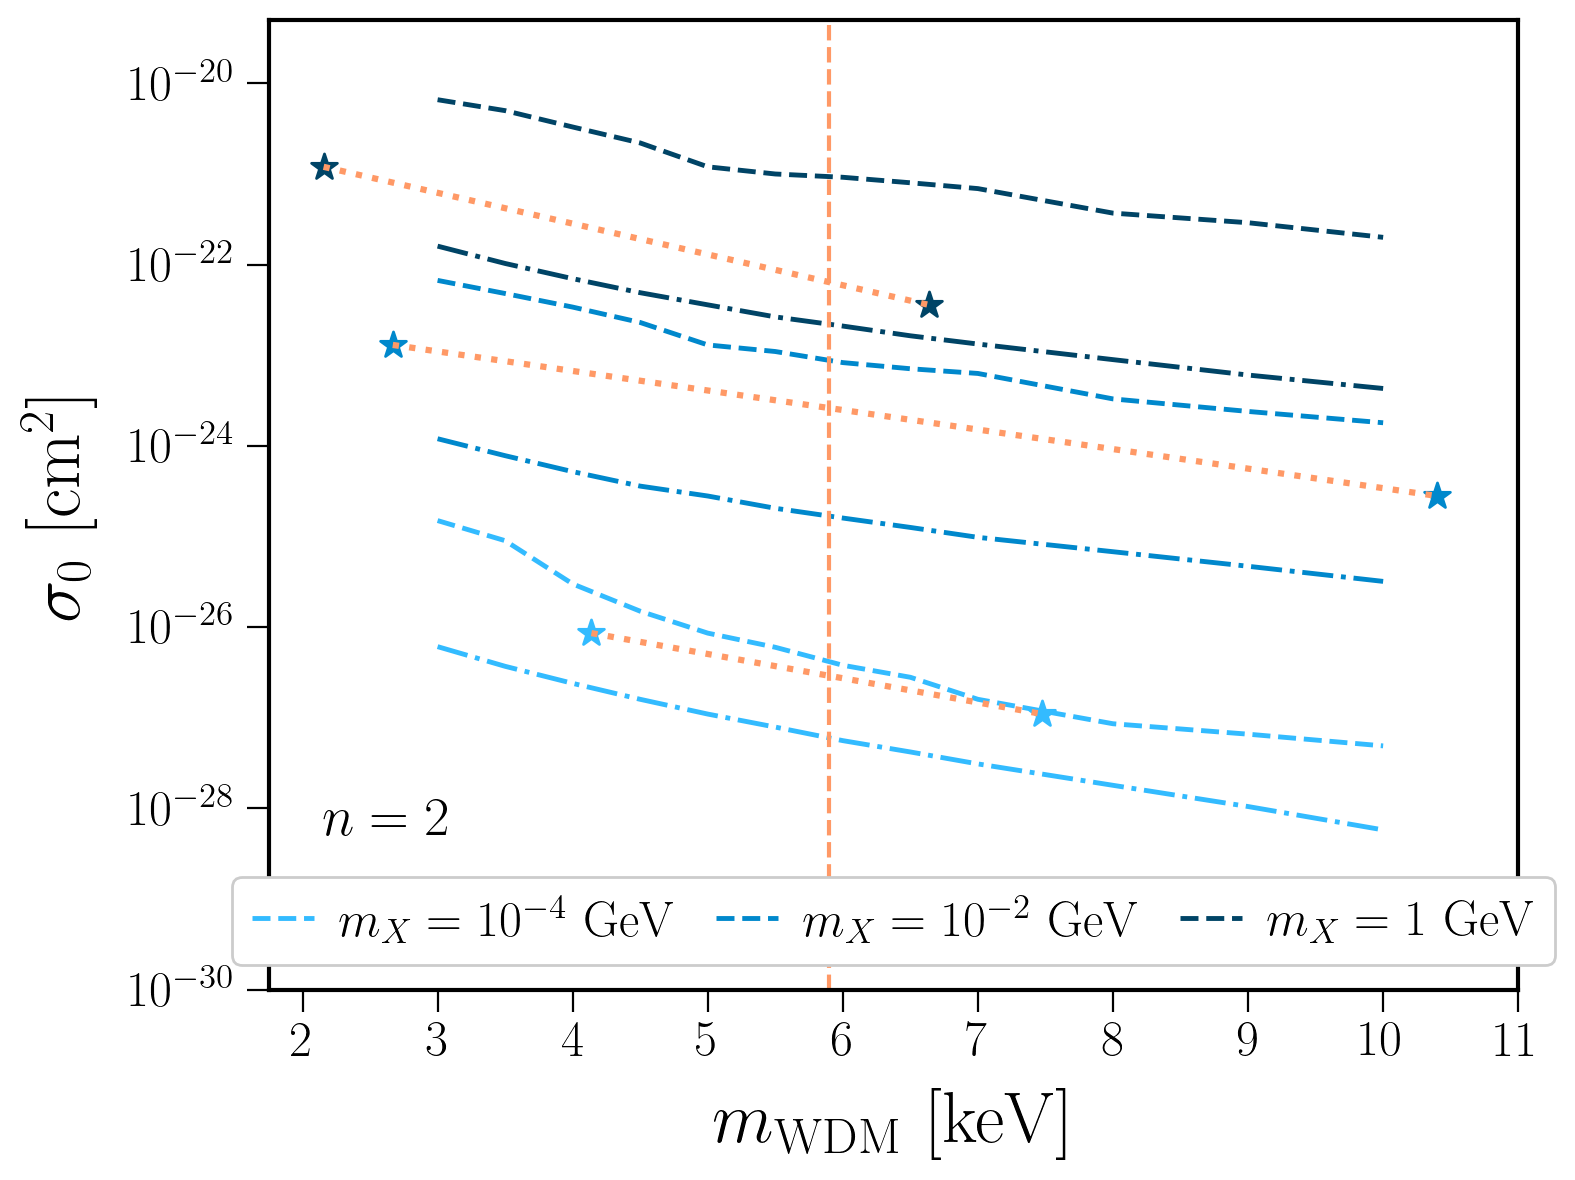

In [33]:
plt.figure(figsize=(8,6))

# Loop over the n=2 data keys
for i,mass in enumerate(cs_values_halfmode_n2.keys()):
    
    # Use the n=2 key structure
    sim_key = 'idm_n2_{}GeV'.format(mass_labels[i])

    plt.semilogy(np.ravel(wdms),np.ravel(cs_values_halfmode_n2[mass]),
                 c=sim_colors[sim_key],ls='-.',lw=1.75)

    # Get the label (this was fixed to prevent the LaTeX error)
    label = labels_idm[sim_key]
    
    plt.semilogy(np.ravel(wdms),np.ravel(cs_values_envelope_n2[mass]),ls='--',lw=1.75,
                 c=sim_colors[sim_key],label=label) # Add the label here

    plt.plot([masses_envelope[sim_key],
              masses_halfmode[sim_key]],
             [cs_values_envelope_n2[mass][4],cs_values_halfmode_n2[mass][4]],
             c=sim_colors['wdm_3'],ls=':',lw=2.25)
    
    plt.scatter(masses_halfmode[sim_key],cs_values_halfmode_n2[mass][4],
                marker='*',s=95,c=sim_colors[sim_key])
    plt.scatter(masses_envelope[sim_key],cs_values_envelope_n2[mass][4],
                marker='*',s=95,c=sim_colors[sim_key])

    
    ### --- Intersection and Star Position Calculation (n=2 case) ---
    
    # --- Star Positions ---
    # Get Half mode star position
    star_halfmode_x = masses_halfmode[sim_key]
    star_halfmode_y = cs_values_halfmode_n2[mass][4] # Use n2 data
    
    # Get Envelope star position
    star_envelope_x = masses_envelope[sim_key]
    star_envelope_y = cs_values_envelope_n2[mass][4] # Use n2 data

    print(f"--- {sim_key} ---")
    print(f"Half mode Star (x, y): ({star_halfmode_x:.2f} keV, {star_halfmode_y:.4e} cm^2)")
    print(f"Envelope Star (x, y):  ({star_envelope_x:.2f} keV, {star_envelope_y:.4e} cm^2)")

    # --- Intersection Calculation ---
    # Calculate log-space coordinates for interpolation
    y1_log = np.log10(star_halfmode_y)
    y2_log = np.log10(star_envelope_y)

    # Calculate the slope (m) and intercept (b) of the line
    m = (y2_log - y1_log) / (star_envelope_x - star_halfmode_x)
    b = y1_log - m * star_halfmode_x
    
    target_x = 5.9
    
    # Solve for the y-value (the cross-section) at that x
    log_y_intersect = m * target_x + b
    cross_section_at_intersect = 10.**(log_y_intersect)
    
    # Print the final result
    print(f"Intersection at {target_x} keV: {cross_section_at_intersect:.4e} cm^2\n")
    
    ### --- End of Calculation ---

    
plt.plot(np.ones(10)*5.9,np.linspace(10**-30,1e-13,10),ls='--',c=sim_colors['wdm_3'])

# Restore n=2 axis limits and ticks
plt.xlim(1.75, 11.)
plt.ylim(10**-30, 5e-20)

plt.xlabel(r'$m_{\mathrm{WDM}}~[\mathrm{keV}]$',fontsize=26,labelpad=8)
plt.ylabel(r'$\sigma_{0}~[\mathrm{cm}^2]$',fontsize=26,labelpad=12)

plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10, 11],fontsize=18)
plt.yticks([1e-30, 1e-28, 1e-26, 1e-24, 1e-22, 1e-20],fontsize=18)

# Use n=2 text and coordinates
plt.text(2.15, 5e-29, r'$n=2$',fontsize=20) 
plt.legend(loc='lower center',ncol=3,handlelength=1.25,columnspacing=0.8,handletextpad=0.5,
           framealpha=1,fontsize=18,frameon=True)

plt.tight_layout()
#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/idm_constraint_n2.pdf')
plt.show()


n = 4 CONSTRAINTS

IDM 1e-4 GeV:
  Half-mode: m_WDM = 7.61 keV, σ = 2.20e-27 cm²
  Envelope:  m_WDM = 4.50 keV, σ = 3.40e-26 cm²
  Interpolated at 5.9 keV: σ = 9.91e-27 cm²

IDM 1e-2 GeV:
  Half-mode: m_WDM = 9.36 keV, σ = 1.70e-22 cm²
  Envelope:  m_WDM = 3.47 keV, σ = 1.70e-19 cm²
  Interpolated at 5.9 keV: σ = 9.83e-21 cm²

IDM 1 GeV:
  Half-mode: m_WDM = 9.66 keV, σ = 8.60e-19 cm²
  Envelope:  m_WDM = 2.84 keV, σ = 2.80e-16 cm²
  Interpolated at 5.9 keV: σ = 2.09e-17 cm²


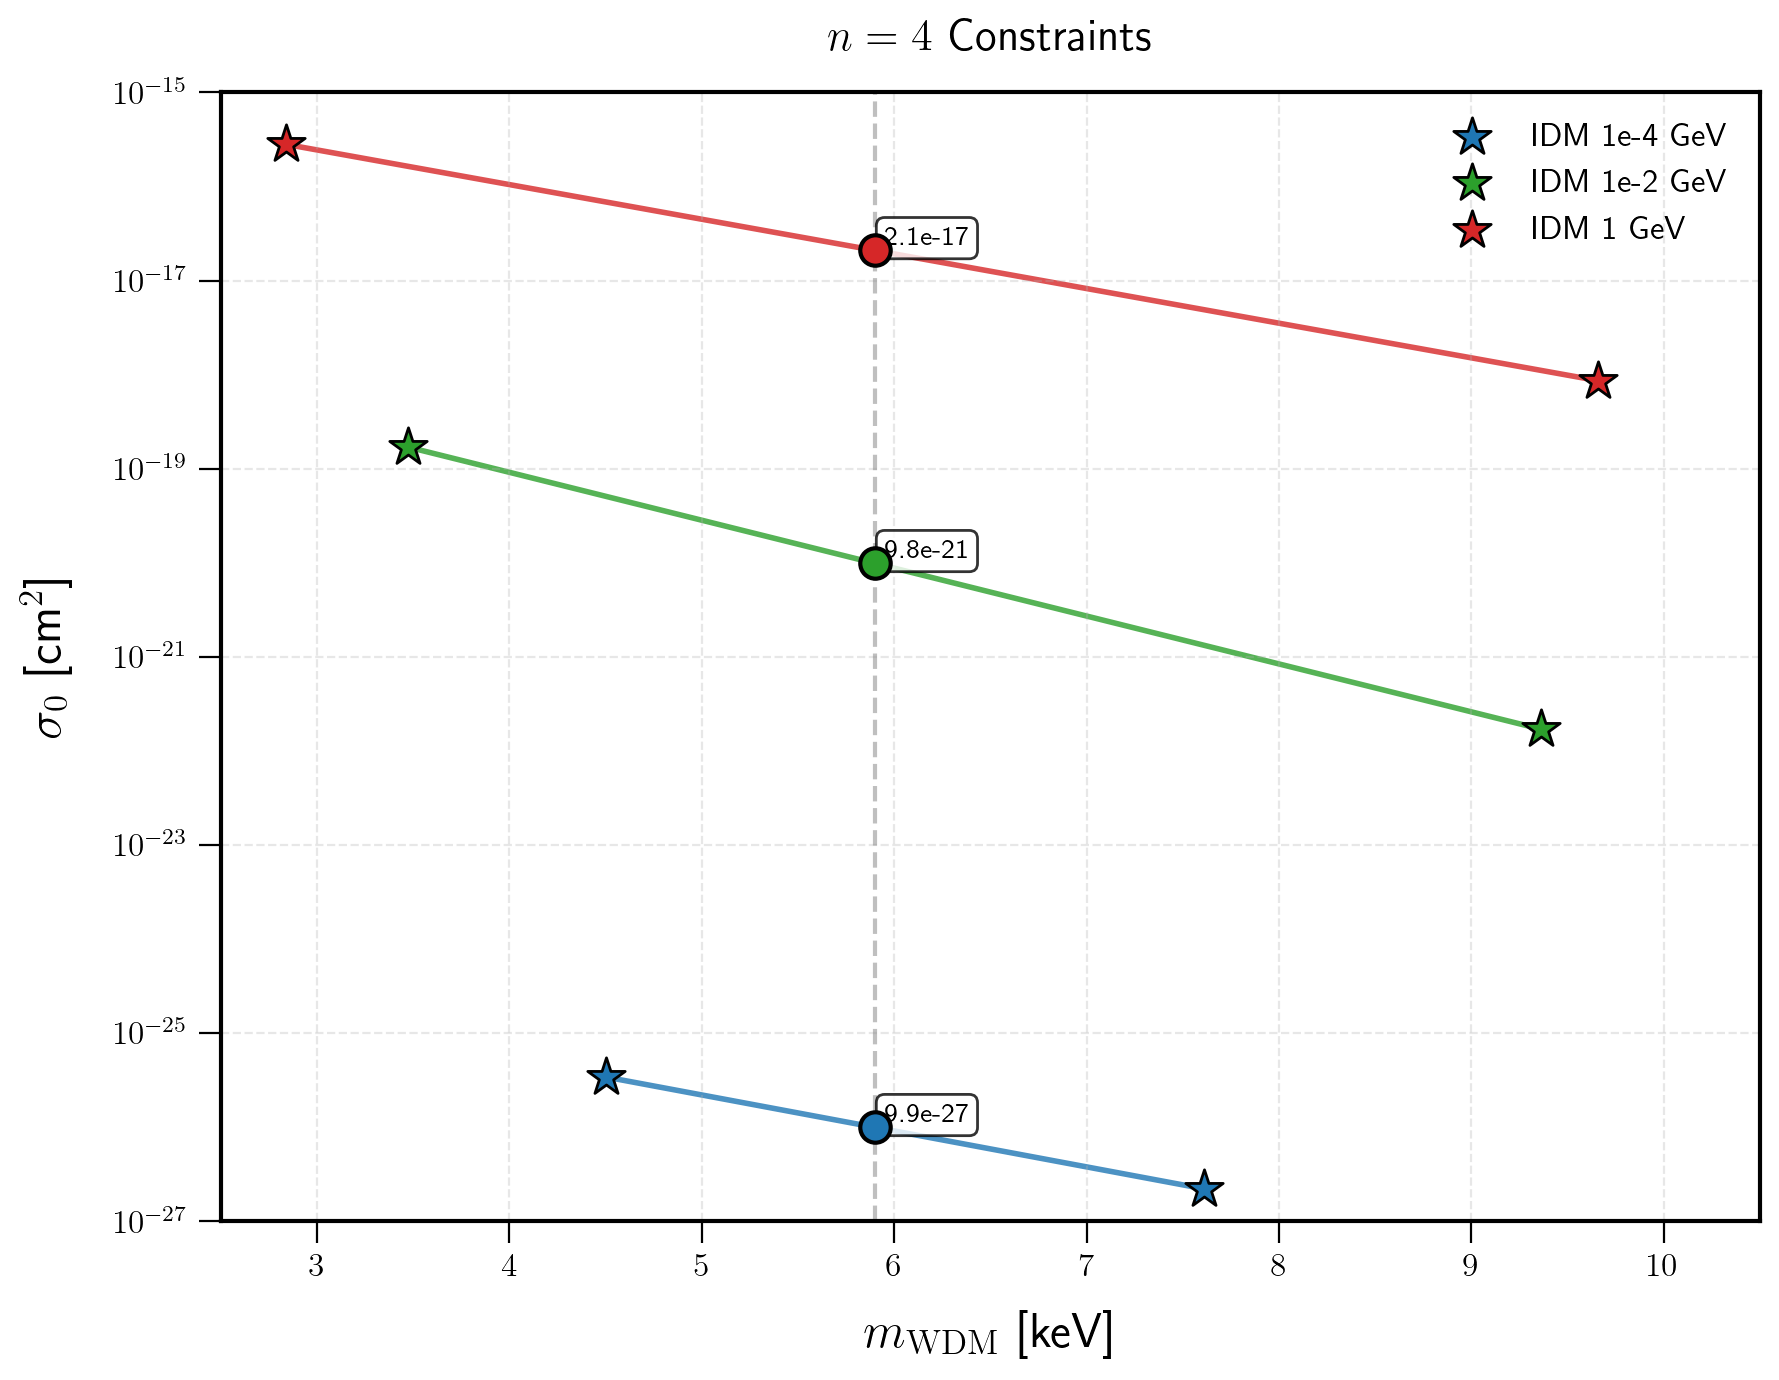


n = 2 CONSTRAINTS

IDM 1e-4 GeV:
  Half-mode: m_WDM = 7.61 keV, σ = 4.20e-28 cm²
  Envelope:  m_WDM = 4.50 keV, σ = 2.80e-27 cm²
  Interpolated at 5.9 keV: σ = 1.19e-27 cm²

IDM 1e-2 GeV:
  Half-mode: m_WDM = 9.36 keV, σ = 1.30e-25 cm²
  Envelope:  m_WDM = 3.47 keV, σ = 7.10e-24 cm²
  Interpolated at 5.9 keV: σ = 1.36e-24 cm²

IDM 1 GeV:
  Half-mode: m_WDM = 9.66 keV, σ = 1.60e-23 cm²
  Envelope:  m_WDM = 2.84 keV, σ = 8.00e-22 cm²
  Interpolated at 5.9 keV: σ = 1.38e-22 cm²


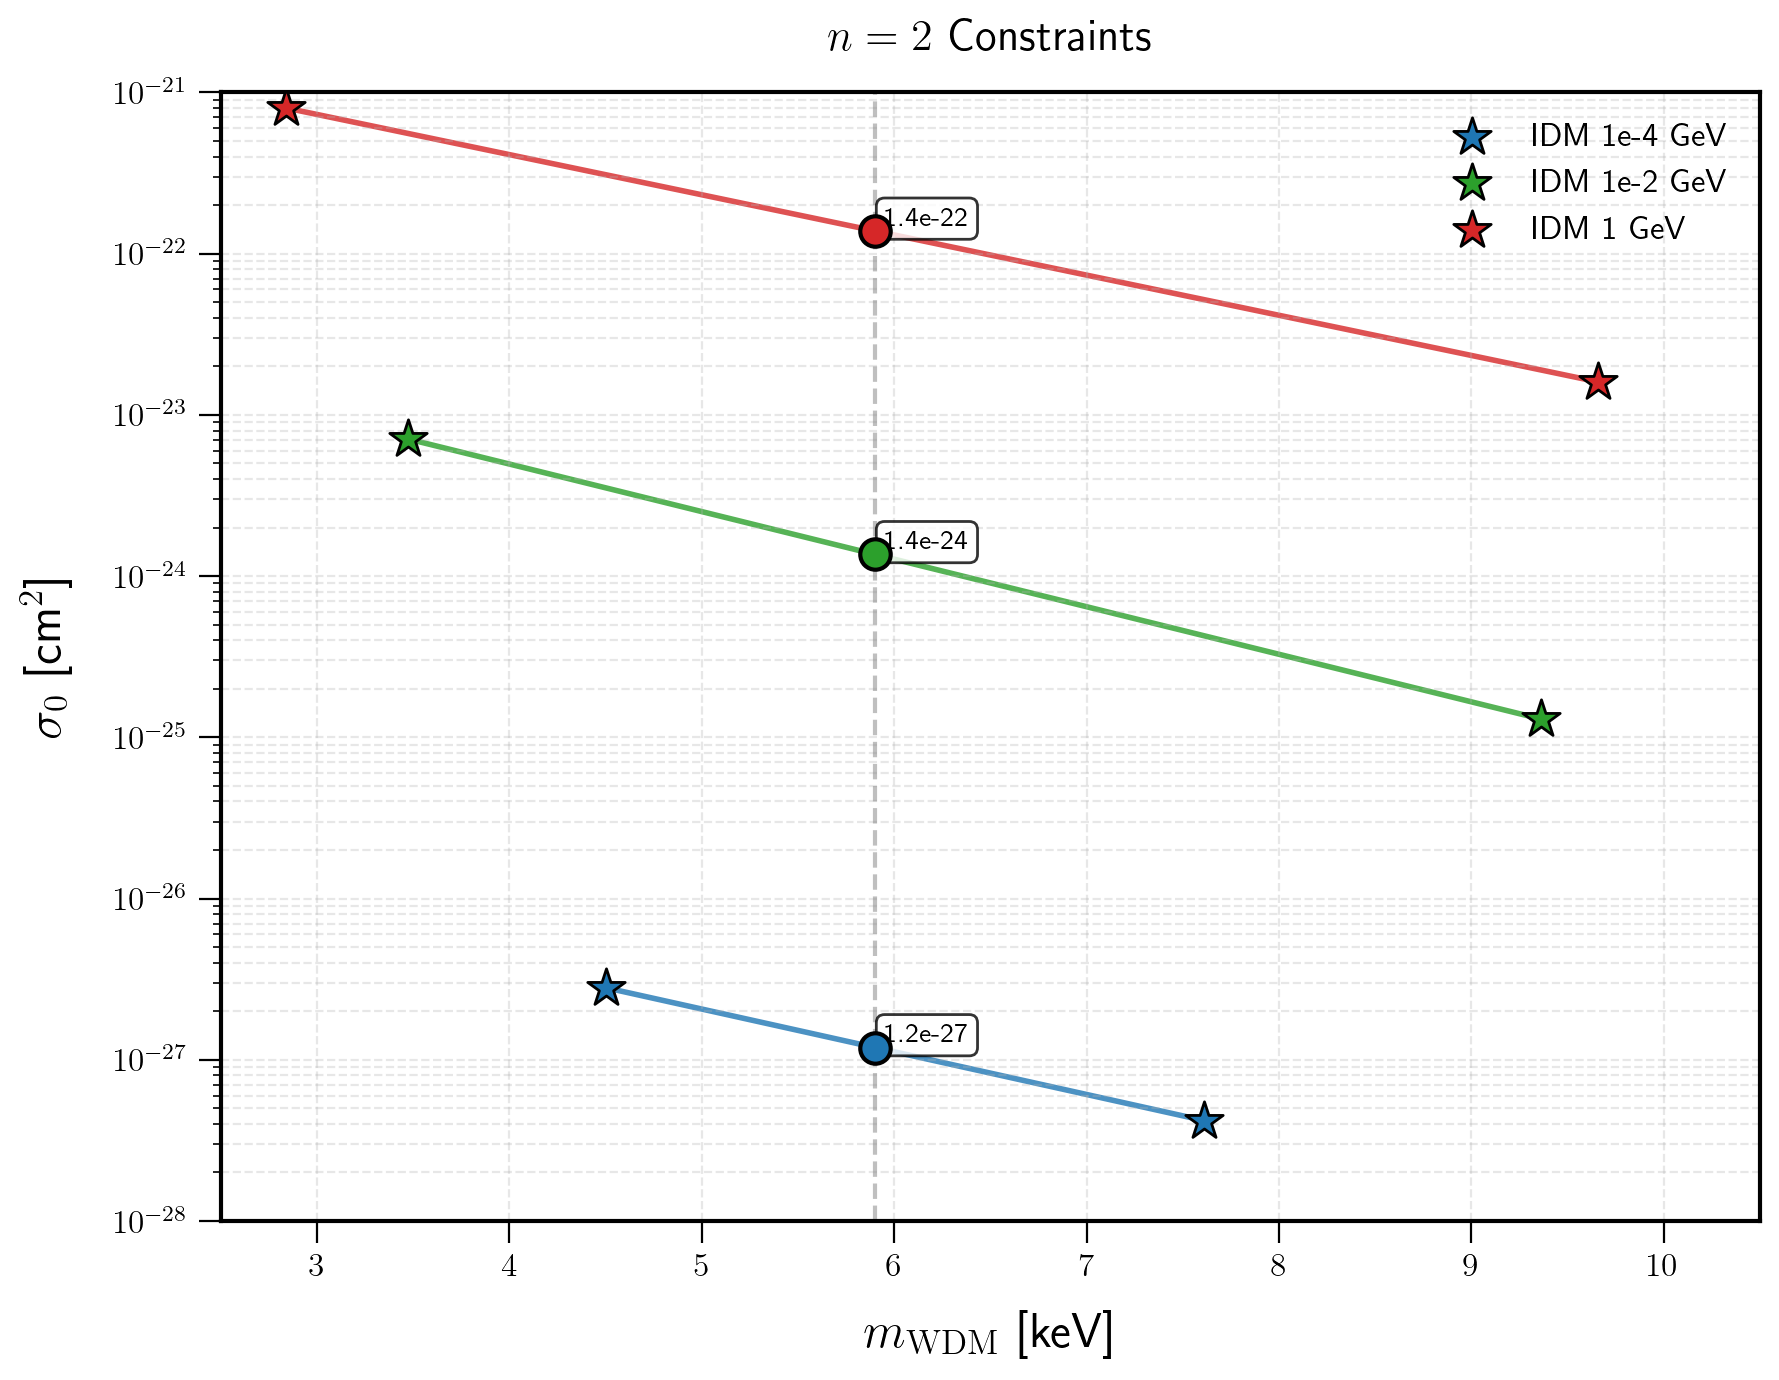


SUMMARY OF ALL INTERPOLATIONS AT 5.9 keV
IDM Mass [GeV]  n=4 σ [cm²]               n=2 σ [cm²]              
----------------------------------------------------------------------
1e-4            9.91e-27                  1.19e-27                 
1e-2            9.83e-21                  1.36e-24                 
1               2.09e-17                  1.38e-22                 

RATIO ANALYSIS: n=4 / n=2 at 5.9 keV
IDM Mass [GeV]  σ_n4/σ_n2            log10(ratio)        
----------------------------------------------------------------------
1e-4            8.32                 0.92                
1e-2            7215.27              3.86                
1               151001.59            5.18                


RuntimeError: latex was not able to process the following string:
b'Interpolated \\u03c3 at 5.9 keV'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpsx060w7g 42bfc552dc5c292f6b8e54aaa026e388.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./42bfc552dc5c292f6b8e54aaa026e388.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 42bfc552dc5c292f6b8e54aaa026e388.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode character σ (U+03C3)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\sffamily Interpolated σ
                                at 5.9 keV}%
No pages of output.
Transcript written on tmpsx060w7g/42bfc552dc5c292f6b8e54aaa026e388.log.




Error in callback <function _draw_all_if_interactive at 0x7f8177d2a700> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'Interpolated \\u03c3 at 5.9 keV'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpzz_6994w 42bfc552dc5c292f6b8e54aaa026e388.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./42bfc552dc5c292f6b8e54aaa026e388.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 42bfc552dc5c292f6b8e54aaa026e388.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode character σ (U+03C3)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\sffamily Interpolated σ
                                at 5.9 keV}%
No pages of output.
Transcript written on tmpzz_6994w/42bfc552dc5c292f6b8e54aaa026e388.log.




RuntimeError: latex was not able to process the following string:
b'Interpolated \\u03c3 at 5.9 keV'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpx6ds3iig 42bfc552dc5c292f6b8e54aaa026e388.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./42bfc552dc5c292f6b8e54aaa026e388.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 42bfc552dc5c292f6b8e54aaa026e388.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode character σ (U+03C3)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\sffamily Interpolated σ
                                at 5.9 keV}%
No pages of output.
Transcript written on tmpx6ds3iig/42bfc552dc5c292f6b8e54aaa026e388.log.




<Figure size 1400x600 with 2 Axes>

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Disable LaTeX to avoid Unicode errors
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'  # Use STIX fonts for Greek letters

# EXACT DATA - From your confirmation:
# n=2 cross-sections:
#   IDM 10^-4 GeV: σ0 = 4.2e-28 cm^2 (half-mode), 2.8e-27 cm^2 (envelope)
#   IDM 10^-2 GeV: σ0 = 1.3e-25 cm^2 (half-mode), 7.1e-24 cm^2 (envelope)
#   IDM 1 GeV: σ0 = 1.6e-23 cm^2 (half-mode), 8.0e-22 cm^2 (envelope)

# n=4 cross-sections:
#   IDM 10^-4 GeV: σ0 = 2.2e-27 cm^2 (half-mode), 3.4e-26 cm^2 (envelope)
#   IDM 10^-2 GeV: σ0 = 1.7e-22 cm^2 (half-mode), 1.7e-19 cm^2 (envelope)
#   IDM 1 GeV: σ0 = 8.6e-19 cm^2 (half-mode), 2.8e-16 cm^2 (envelope)

# WDM masses from COZMIC 1 (first screenshot):
# Half-mode masses: ~7.61, 9.36, 9.66 keV
# Envelope masses: ~4.50, 3.47, 2.84 keV

# Create data structure
data = {
    'n4': {
        '1e-4': {
            'halfmode': {'m_wdm': 7.61, 'sigma': 2.2e-27},
            'envelope': {'m_wdm': 4.50, 'sigma': 3.4e-26}
        },
        '1e-2': {
            'halfmode': {'m_wdm': 9.36, 'sigma': 1.7e-22},
            'envelope': {'m_wdm': 3.47, 'sigma': 1.7e-19}
        },
        '1': {
            'halfmode': {'m_wdm': 9.66, 'sigma': 8.6e-19},
            'envelope': {'m_wdm': 2.84, 'sigma': 2.8e-16}
        }
    },
    'n2': {
        '1e-4': {
            'halfmode': {'m_wdm': 7.61, 'sigma': 4.2e-28},
            'envelope': {'m_wdm': 4.50, 'sigma': 2.8e-27}
        },
        '1e-2': {
            'halfmode': {'m_wdm': 9.36, 'sigma': 1.3e-25},
            'envelope': {'m_wdm': 3.47, 'sigma': 7.1e-24}
        },
        '1': {
            'halfmode': {'m_wdm': 9.66, 'sigma': 1.6e-23},
            'envelope': {'m_wdm': 2.84, 'sigma': 8.0e-22}
        }
    }
}

# Colors for different IDM masses
colors = {
    '1e-4': '#1f77b4',  # blue
    '1e-2': '#2ca02c',  # green
    '1': '#d62728'      # red
}

# Interpolation function
def interpolate_at_59keV(m1, s1, m2, s2):
    """
    Linear interpolation in log space between points (m1, s1) and (m2, s2)
    to find sigma at m = 5.9 keV.
    
    Parameters:
    m1, m2: WDM masses in keV
    s1, s2: cross-sections in cm^2
    """
    # Convert to log10
    log_s1 = np.log10(s1)
    log_s2 = np.log10(s2)
    
    # Linear interpolation in log space
    slope = (log_s2 - log_s1) / (m2 - m1)
    intercept = log_s1 - slope * m1
    
    # Calculate at 5.9 keV
    log_s_interp = slope * 5.9 + intercept
    s_interp = 10**log_s_interp
    
    return s_interp

# Function to plot constraints
def plot_constraints(n_value):
    """Plot constraints for given n value"""
    
    fig, ax = plt.subplots(figsize=(9, 7))
    
    # Get data for this n value
    n_data = data[f'n{n_value}']
    
    print(f"\n{'='*60}")
    print(f"n = {n_value} CONSTRAINTS")
    print(f"{'='*60}")
    
    # For each IDM mass
    for mass_key in ['1e-4', '1e-2', '1']:
        mass_data = n_data[mass_key]
        
        # Extract points
        m_half = mass_data['halfmode']['m_wdm']
        s_half = mass_data['halfmode']['sigma']
        m_env = mass_data['envelope']['m_wdm']
        s_env = mass_data['envelope']['sigma']
        
        color = colors[mass_key]
        
        # Interpolate at 5.9 keV
        s_59 = interpolate_at_59keV(m_half, s_half, m_env, s_env)
        
        # Print results
        print(f"\nIDM {mass_key} GeV:")
        print(f"  Half-mode: m_WDM = {m_half:.2f} keV, σ = {s_half:.2e} cm²")
        print(f"  Envelope:  m_WDM = {m_env:.2f} keV, σ = {s_env:.2e} cm²")
        print(f"  Interpolated at 5.9 keV: σ = {s_59:.2e} cm²")
        
        # Plot connecting line
        ax.plot([m_env, m_half], [s_env, s_half], 
                color=color, linestyle='-', linewidth=2, alpha=0.8, zorder=1)
        
        # Plot the constraint points (stars)
        ax.scatter(m_half, s_half, marker='*', s=200, 
                   color=color, edgecolor='black', linewidth=1, 
                   label=f'IDM {mass_key} GeV', zorder=3)
        ax.scatter(m_env, s_env, marker='*', s=200,
                   color=color, edgecolor='black', linewidth=1, zorder=3)
        
        # Plot interpolated point at 5.9 keV
        ax.scatter(5.9, s_59, marker='o', s=120,
                   color=color, edgecolor='black', linewidth=1.5, zorder=4)
        
        # Add label near interpolated point
        ax.text(5.95, s_59, f'{s_59:.1e}', fontsize=10, 
                verticalalignment='bottom', horizontalalignment='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Add vertical line at 5.9 keV
    ax.axvline(x=5.9, color='gray', linestyle='--', alpha=0.5, linewidth=1.5, zorder=2)
    
    # Set log scale for y-axis
    ax.set_yscale('log')
    
    # Set axis limits
    if n_value == 4:
        ax.set_xlim(2.5, 10.5)
        ax.set_ylim(1e-27, 1e-15)
        ylabel_pad = 15
    else:  # n=2
        ax.set_xlim(2.5, 10.5)
        ax.set_ylim(1e-28, 1e-21)
        ylabel_pad = 15
    
    # Labels - using matplotlib's math rendering instead of LaTeX
    ax.set_xlabel(r'$m_{WDM}$ [keV]', fontsize=18, labelpad=10)
    ax.set_ylabel(r'$\sigma_0$ [cm$^2$]', fontsize=18, labelpad=ylabel_pad)
    
    # Title
    ax.set_title(f'n = {n_value} Constraints', fontsize=16, pad=15)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--', which='both')
    
    # Legend
    ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
    
    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    
    plt.tight_layout()
    plt.show()

# Generate plots and calculations
plot_constraints(4)
plot_constraints(2)

# Now create a summary table
print("\n" + "="*70)
print("SUMMARY OF ALL INTERPOLATIONS AT 5.9 keV")
print("="*70)
print(f"{'IDM Mass [GeV]':<15} {'n=4 σ [cm²]':<25} {'n=2 σ [cm²]':<25}")
print("-"*70)

for mass_key in ['1e-4', '1e-2', '1']:
    # n=4 interpolation
    n4_data = data['n4'][mass_key]
    n4_s59 = interpolate_at_59keV(
        n4_data['halfmode']['m_wdm'], n4_data['halfmode']['sigma'],
        n4_data['envelope']['m_wdm'], n4_data['envelope']['sigma']
    )
    
    # n=2 interpolation
    n2_data = data['n2'][mass_key]
    n2_s59 = interpolate_at_59keV(
        n2_data['halfmode']['m_wdm'], n2_data['halfmode']['sigma'],
        n2_data['envelope']['m_wdm'], n2_data['envelope']['sigma']
    )
    
    print(f"{mass_key:<15} {n4_s59:<25.2e} {n2_s59:<25.2e}")

print("="*70)

# Additional analysis: Compare n=4 vs n=2
print("\n" + "="*70)
print("RATIO ANALYSIS: n=4 / n=2 at 5.9 keV")
print("="*70)
print(f"{'IDM Mass [GeV]':<15} {'σ_n4/σ_n2':<20} {'log10(ratio)':<20}")
print("-"*70)

for mass_key in ['1e-4', '1e-2', '1']:
    # Calculate interpolations
    n4_data = data['n4'][mass_key]
    n4_s59 = interpolate_at_59keV(
        n4_data['halfmode']['m_wdm'], n4_data['halfmode']['sigma'],
        n4_data['envelope']['m_wdm'], n4_data['envelope']['sigma']
    )
    
    n2_data = data['n2'][mass_key]
    n2_s59 = interpolate_at_59keV(
        n2_data['halfmode']['m_wdm'], n2_data['halfmode']['sigma'],
        n2_data['envelope']['m_wdm'], n2_data['envelope']['sigma']
    )
    
    ratio = n4_s59 / n2_s59
    log_ratio = np.log10(ratio)
    
    print(f"{mass_key:<15} {ratio:<20.2f} {log_ratio:<20.2f}")

print("="*70)

# Create a simple comparison plot without fancy titles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot n=4 and n=2 on same axes for comparison
ax1.set_title('Comparison: n=4 vs n=2', fontsize=16, pad=15)

for mass_key in ['1e-4', '1e-2', '1']:
    color = colors[mass_key]
    
    # n=4 line
    n4_data = data['n4'][mass_key]
    ax1.plot([n4_data['envelope']['m_wdm'], n4_data['halfmode']['m_wdm']],
             [n4_data['envelope']['sigma'], n4_data['halfmode']['sigma']],
             color=color, linestyle='-', linewidth=2.5, alpha=0.8,
             label=f'IDM {mass_key} GeV (n=4)')
    
    # n=2 line (dashed)
    n2_data = data['n2'][mass_key]
    ax1.plot([n2_data['envelope']['m_wdm'], n2_data['halfmode']['m_wdm']],
             [n2_data['envelope']['sigma'], n2_data['halfmode']['sigma']],
             color=color, linestyle='--', linewidth=2, alpha=0.8,
             label=f'IDM {mass_key} GeV (n=2)')

ax1.axvline(x=5.9, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
ax1.set_xlabel(r'$m_{WDM}$ [keV]', fontsize=14)
ax1.set_ylabel(r'$\sigma_0$ [cm$^2$]', fontsize=14)
ax1.set_yscale('log')
ax1.set_xlim(2.5, 10.5)
ax1.set_ylim(1e-28, 1e-15)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=10, ncol=2)

# Bar chart of interpolated values at 5.9 keV (without Greek letters in title)
ax2.set_title('Interpolated Values at 5.9 keV', fontsize=16, pad=15)

x_pos = np.arange(3)  # 3 IDM masses
width = 0.35

n4_values = []
n2_values = []
labels = []

for i, mass_key in enumerate(['1e-4', '1e-2', '1']):
    # Calculate interpolations
    n4_data = data['n4'][mass_key]
    n4_s59 = interpolate_at_59keV(
        n4_data['halfmode']['m_wdm'], n4_data['halfmode']['sigma'],
        n4_data['envelope']['m_wdm'], n4_data['envelope']['sigma']
    )
    
    n2_data = data['n2'][mass_key]
    n2_s59 = interpolate_at_59keV(
        n2_data['halfmode']['m_wdm'], n2_data['halfmode']['sigma'],
        n2_data['envelope']['m_wdm'], n2_data['envelope']['sigma']
    )
    
    n4_values.append(n4_s59)
    n2_values.append(n2_s59)
    labels.append(f'IDM {mass_key}')

bars1 = ax2.bar(x_pos - width/2, n4_values, width, label='n=4', 
                color=['#1f77b4', '#2ca02c', '#d62728'], edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, n2_values, width, label='n=2',
                color=['#1f77b4', '#2ca02c', '#d62728'], edgecolor='black', alpha=0.7)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.1e}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(bars1)
autolabel(bars2)

ax2.set_xlabel('IDM Model', fontsize=14)
ax2.set_ylabel('Cross-section [cm²]', fontsize=14)  # Plain text instead of math
ax2.set_xticks(x_pos)
ax2.set_xticklabels(labels)
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

In [34]:
# The WDM mass (x-value) where we want to find the intersection
target_wdm_mass = 5.9  # <--- This is the 6.0 keV from your prompt
    
# Get the coordinates of the two stars (the endpoints of the dotted line)
# Point 1 (halfmode)
x1 = masses_halfmode['idm_n2_{}GeV'.format(mass_labels[i])]
y1_log = np.log10(cs_values_halfmode_n2[mass][4])
    
# Point 2 (envelope)
x2 = masses_envelope['idm_n2_{}GeV'.format(mass_labels[i])]
y2_log = np.log10(cs_values_envelope_n2[mass][4])
    
# Calculate the slope (m) and intercept (b) of the log-linear line
# log10(y) = m*x + b
m = (y2_log - y1_log) / (x2 - x1)
b = y1_log - m * x1
    
# Now, find the log10(y) value at our target x-value
log_y_intersect = m * target_wdm_mass + b
    
# Convert back from log-space to get the final cross-section
cross_section_at_6kev = 10**log_y_intersect
    
# Get a clean label for printing
label_key = 'idm_n2_{}GeV'.format(mass_labels[i])
    
print(f"--- {label_key} ---")
print(f"Intersection at {target_wdm_mass} keV: {cross_section_at_6kev:.4e} cm^2\n")



--- idm_n2_1GeV ---
Intersection at 5.9 keV: 6.4057e-23 cm^2



### Transfers (old)

NameError: name 'x3' is not defined

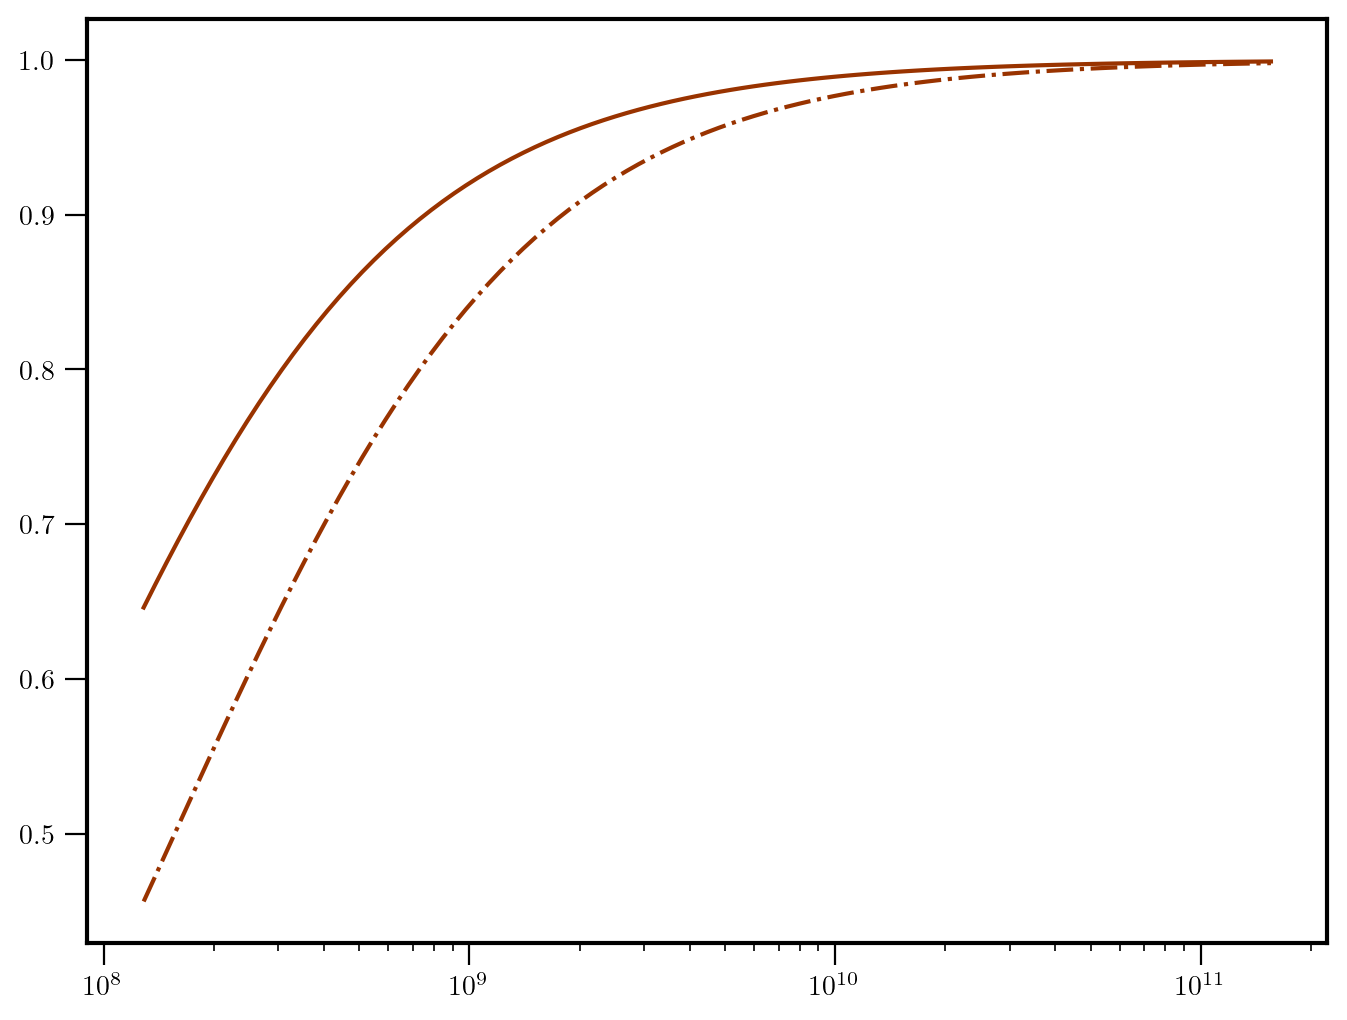

In [14]:
df_mcmc = pd.read_pickle('/central/groups/carnegie_poc/enadler/ncdm_resims/analysis/df_wdm.pkl')
base_mpeak = np.logspace(np.log10(3e5*300/0.7),np.log10(9e5*1.3e5/0.7),100)
x=0.5*(base_mpeak[1:]+base_mpeak[:-1])

labels = {'wdm_3': r'$m_{\mathrm{WDM}}=3~\mathrm{keV}$', 'wdm_4': r'$m_{\mathrm{WDM}}=4~\mathrm{keV}$',
          'wdm_5': r'$m_{\mathrm{WDM}}=5~\mathrm{keV}$', 'wdm_6': r'$m_{\mathrm{WDM}}=6~\mathrm{keV}$',
          'wdm_6.5': r'$m_{\mathrm{WDM}}=6.5~\mathrm{keV}$', 'wdm_10': r'$m_{\mathrm{WDM}}=10~\mathrm{keV}$',
         'cdm':r'$\mathrm{CDM}$'}

plt.figure(figsize=(8,6))
plt.xscale('log')
    
pred_dict = {}
masses_halfmode = {}

a_max, b_max, alpha_max, beta_max, gamma_max = 1.34, 0.959, 2.5, 0.9, 1.0

pred = (1.+(alpha_max*Mhm(6.5)/x)**beta_max)**(-1.*gamma_max)
plt.plot(base_mpeak[:-1],pred,
                        c=sim_colors['wdm_6.5'],ls='-',lw=1.5)

pred = (1.+(alpha_max*Mhm(5.1)/x)**beta_max)**(-1.*gamma_max)
plt.plot(base_mpeak[:-1],pred,
                        c=sim_colors['wdm_6.5'],ls='-.',lw=1.5)

# pred = (1.+(alpha_max*Mhm(7.5)/x)**beta_max)**(-1.*gamma_max)
# plt.plot(base_mpeak[:-1],pred,
#                         c=sim_colors['wdm_6.5'],ls='--',lw=1.5)

# pred = (1.+(alpha_max*Mhm(8.5)/x)**beta_max)**(-1.*gamma_max)
# plt.plot(base_mpeak[:-1],pred,
#                         c=sim_colors['wdm_6.5'],ls='-.',lw=1.5)

# pred = (1.+(alpha_max*Mhm(9.5)/x)**beta_max)**(-1.*gamma_max)
# plt.plot(base_mpeak[:-1],pred,
#                         c=sim_colors['wdm_6.5'],ls=':',lw=1.5)

for j,model in enumerate(models):
    if model == 'cdm':
        continue
    else:
        for k,method in enumerate(methods):
            if method == 'envelope':
                continue
            plt.scatter(10.**(0.5*(x3[:-1]+x3[1:])),ratio[model][method],c=sim_colors[model],linestyle=linestyles[method])
            diff = []
            for mwdm in np.linspace(7,11,1000):
                pred = (1.+(alpha_max*Mhm(mwdm)/10.**(0.5*(x3[:-1]+x3[1:])))**beta_max)**(-1.*gamma_max)
                obs = ratio[model][method][0]
                diff.append(np.sum((pred[0]-obs)**2))
            diff = np.array(diff)
            print(model)
            print(np.linspace(7,11,1000)[np.argmin(diff)])
            pred = (1.+(alpha_max*Mhm(np.linspace(7,11,1000)[np.argmin(diff)])/x)**beta_max)**(-1.*gamma_max)
            masses_halfmode[model] = np.linspace(7,11,1000)[np.argmin(diff)]
            plt.plot(base_mpeak[:-1],pred,
                        c=sim_colors[model],ls='--',lw=1.5)

    # plt.scatter(10.**(0.5*(x3[:-1]+x3[1:])),ratio[model],c=sim_colors[model])
    

# plt.legend(handles=[wdm_plot[0][0],wdm_plot[1][0],wdm_plot[2][0],wdm_plot[3][0],wdm_plot[4][0],wdm_plot[5][0]],
#            loc=4,fontsize=16,frameon=False,framealpha=1.0,ncol=1)
plt.plot(np.linspace(1e8,1e10,10),np.ones(10),'k--',lw=0.5)
plt.xlim(1e8,2*10**10)
# plt.xticks([10**8,10**9,10**10],[r'$10^8$',r'$10^9$',r'$10^{10}$'], fontsize=20)
plt.ylim(0.6,1.)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks([0.2,0.4,0.6,0.8,1.0],[r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'], fontsize=20)
# plt.yticks([2,3,4,5,6,7,8,9,11,12,13,14],['','','','','','','','','','','',''], minor=True)
plt.xlabel(r'$M_{\rm{sub,peak}}\ [M_{\mathrm{\odot}}]$',fontsize=26,labelpad=8)
plt.ylabel(r'$f_{\mathrm{beyond-CDM}}$', fontsize=26, labelpad=12)
# plt.yscale('log')
plt.ylim(0.6,1.15)
# plt.ylim(1,20)

plt.tight_layout()
# plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/wdm_f_pred.pdf')
plt.show()

In [ ]:
df_mcmc = pd.read_pickle('/central/groups/carnegie_poc/enadler/ncdm_resims/analysis/df_wdm.pkl')
base_mpeak = np.logspace(np.log10(3e5*300/0.7),np.log10(9e5*1.3e5/0.7),100)
x=0.5*(base_mpeak[1:]+base_mpeak[:-1])

labels = {'wdm_3': r'$m_{\mathrm{WDM}}=3~\mathrm{keV}$', 'wdm_4': r'$m_{\mathrm{WDM}}=4~\mathrm{keV}$',
          'wdm_5': r'$m_{\mathrm{WDM}}=5~\mathrm{keV}$', 'wdm_6': r'$m_{\mathrm{WDM}}=6~\mathrm{keV}$',
          'wdm_6.5': r'$m_{\mathrm{WDM}}=6.5~\mathrm{keV}$', 'wdm_10': r'$m_{\mathrm{WDM}}=10~\mathrm{keV}$',
         'cdm':r'$\mathrm{CDM}$'}

plt.figure(figsize=(8,6))
plt.xscale('log')
    
pred_dict = {}
masses_envelope = {}

a_max, b_max, alpha_max, beta_max, gamma_max = 1.34, 0.959, 2.5, 0.9, 1.0

pred = (1.+(alpha_max*Mhm(6.5)/x)**beta_max)**(-1.*gamma_max)
plt.plot(base_mpeak[:-1],pred,
                        c=sim_colors['wdm_6.5'],ls='-',lw=1.5)

# pred = (1.+(alpha_max*Mhm(3.5)/x)**beta_max)**(-1.*gamma_max)
# plt.plot(base_mpeak[:-1],pred,
#                         c=sim_colors['wdm_3'],ls='--',lw=1.5)

# pred = (1.+(alpha_max*Mhm(4)/x)**beta_max)**(-1.*gamma_max)
# plt.plot(base_mpeak[:-1],pred,
#                         c=sim_colors['wdm_3'],ls='-.',lw=1.5)

# pred = (1.+(alpha_max*Mhm(4.5)/x)**beta_max)**(-1.*gamma_max)
# plt.plot(base_mpeak[:-1],pred,
#                         c=sim_colors['wdm_3'],ls=':',lw=1.5)

for j,model in enumerate(models):
    if model == 'cdm':
        continue
    else:
        for k,method in enumerate(methods):
            if method == 'halfmode':
                continue
            plt.scatter(10.**(0.5*(x3[:-1]+x3[1:])),ratio[model][method],c=sim_colors[model],linestyle=linestyles[method])
            diff = []
            for mwdm in np.linspace(2,5,1000):
                pred = (1.+(alpha_max*Mhm(mwdm)/10.**(0.5*(x3[:-1]+x3[1:])))**beta_max)**(-1.*gamma_max)
                obs = ratio[model][method][0]
                diff.append(np.sum((pred[0]-obs)**2))
            diff = np.array(diff)
            print(model)
            print(np.linspace(2,5,1000)[np.argmin(diff)])
            pred = (1.+(alpha_max*Mhm(np.linspace(2,5,1000)[np.argmin(diff)])/x)**beta_max)**(-1.*gamma_max)
            masses_envelope[model] = np.linspace(2,5,1000)[np.argmin(diff)]
            plt.plot(base_mpeak[:-1],pred,
                        c=sim_colors[model],ls='--',lw=1.5)

    # plt.scatter(10.**(0.5*(x3[:-1]+x3[1:])),ratio[model],c=sim_colors[model])
    

# plt.legend(handles=[wdm_plot[0][0],wdm_plot[1][0],wdm_plot[2][0],wdm_plot[3][0],wdm_plot[4][0],wdm_plot[5][0]],
#            loc=4,fontsize=16,frameon=False,framealpha=1.0,ncol=1)
plt.plot(np.linspace(1e8,1e10,10),np.ones(10),'k--',lw=0.5)
plt.xlim(1e8,2*10**9)
# plt.xticks([10**8,10**9,10**10],[r'$10^8$',r'$10^9$',r'$10^{10}$'], fontsize=20)
plt.ylim(0.01,0.9)
# plt.yticks([0.2,0.4,0.6,0.8,1.0],[r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'], fontsize=20)
# plt.yticks([2,3,4,5,6,7,8,9,11,12,13,14],['','','','','','','','','','','',''], minor=True)
plt.xlabel(r'$M_{\rm{sub,peak}}\ [M_{\mathrm{\odot}}]$',fontsize=26,labelpad=8)
plt.ylabel(r'$f_{\mathrm{beyond-CDM}}$', fontsize=26, labelpad=12)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yscale('log')
# plt.ylim(0.6,1)
# plt.ylim(1,20)

plt.tight_layout()
# plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/wdm_f_pred.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)

kvec = np.logspace(0, np.log10(500), 1000)
for model in models:
    if model == 'cdm':
        continue
    if 'n2' in model:
        ax.plot(kvec*0.7, transfer(kvec, masses_halfmode[model])**2, color=sim_colors[model],linestyle='--')

halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{Matched\ WDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{IDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

    
m4 = ax.semilogx(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')

ax.semilogx(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{half}$-$\mathrm{mode}$')

print('2','1e-4GeV','halfmode')
print((idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['2']['1e-4GeV']['halfmode'][:,0]**3*idm_transfers['2']['1e-4GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode'])-0.25))
k_short = idm_transfers['2']['1e-4GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['halfmode'])[minimum_ind:]
print((idm_transfers['2']['1e-4GeV']['halfmode'][:,0]*0.7)[halfmode_ind])
print(k_short[24])
print(idm_transfer_short[24])
print('\n')

m2 = ax.semilogx(idm_transfers['2']['1e-2GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')

print('2','1e-2GeV','halfmode')
print((idm_transfers['2']['1e-2GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['2']['1e-2GeV']['halfmode'][:,0]**3*idm_transfers['2']['1e-2GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode'])-0.1))
k_short = idm_transfers['2']['1e-2GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['halfmode'])[minimum_ind:]
print((idm_transfers['2']['1e-2GeV']['halfmode'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

m0 = ax.semilogx(idm_transfers['2']['1GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode']),
             lw=2,c=sim_colors['idm_n2_1GeV'],label='$m_{\mathrm{DM}}=10^{0}\ \mathrm{GeV}$')

print('2','1GeV','halfmode')
print((idm_transfers['2']['1GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['2']['1GeV']['halfmode'][:,0]**3*idm_transfers['2']['1GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode'])-0.1))
k_short = idm_transfers['2']['1GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['2']['1GeV']['halfmode'])[minimum_ind:]
print((idm_transfers['2']['1GeV']['halfmode'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[envelope[0],halfmode[0]], loc=2, fontsize=16, frameon=False, bbox_to_anchor = (0.0,0.95))
ax.text(1.2,0.335,r'$n=2,\ \mathrm{half}$-$\mathrm{mode}$',fontsize=20)

#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_idm_n2_halfmode_wdm.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)

kvec = np.logspace(0, np.log10(500), 1000)
for model in models:
    if model == 'cdm':
        continue
    if 'n2' in model:
        ax.plot(kvec*0.7, transfer(kvec, masses_envelope[model])**2, color=sim_colors[model],linestyle='--')

halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{Matched\ WDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{IDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1e-4GeV'],label='$\mathrm{IDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('2','1e-4GeV','envelope')
print((idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['2']['1e-4GeV']['envelope'][:,0]**3*idm_transfers['2']['1e-4GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope'])-0.01))
k_short = idm_transfers['2']['1e-4GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope'])[minimum_ind:]
print((idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.semilogx(idm_transfers['2']['1e-2GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1e-2GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('2','1e-2GeV','envelope')
print((idm_transfers['2']['1e-2GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['2']['1e-2GeV']['envelope'][:,0]**3*idm_transfers['2']['1e-2GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope'])-0.1))
k_short = idm_transfers['2']['1e-2GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-2GeV']['envelope'])[minimum_ind:]
print((idm_transfers['2']['1e-2GeV']['envelope'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.semilogx(idm_transfers['2']['1GeV']['envelope'][:,0]*0.7,
             (idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_n2_1GeV'])#,label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('2','1GeV','envelope')
print((idm_transfers['2']['1GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['2']['1GeV']['envelope'][:,0]**3*idm_transfers['2']['1GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope'])-0.1))
k_short = idm_transfers['2']['1GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['2']['1GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1GeV']['envelope'])[minimum_ind:]
print((idm_transfers['2']['1GeV']['envelope'][:,0]*0.7)[halfmode_ind])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[envelope[0],halfmode[0]], loc=1, fontsize=16, frameon=False, bbox_to_anchor = (1.0,0.95))
ax.text(1.2,0.335,r'$n=2,\ \mathrm{envelope}$',fontsize=20)

#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_idm_n2_envelope_wdm.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)

kvec = np.logspace(0, np.log10(500), 1000)
for model in models:
    if model == 'cdm':
        continue
    elif 'n2' in model:
        continue
    else:
        ax.plot(kvec*0.7, transfer(kvec, masses_envelope[model])**2, color=sim_colors[model],linestyle='--')
    
halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_1e-4GeV'],label='$\mathrm{Matched\ WDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1e-4GeV'],label='$\mathrm{IDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)


# m4 = ax.semilogx(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7,
#              (idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode']),
#              lw=2,c=sim_colors['idm_n4_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')

# print('4','1e-4GeV','halfmode')
# print((idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]**3*idm_transfers['4']['1e-4GeV']['halfmode'][:,1])])
# halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode'])-0.25))
# minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode'])-0.25))
# k_short = idm_transfers['4']['1e-4GeV']['halfmode'][:,0][minimum_ind:]*0.7
# idm_transfer_short = (idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode'])[minimum_ind:]
# print((idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7)[halfmode_ind])
# print(k_short[46])
# print(idm_transfer_short[46])
# print('\n')

# halfmode = ax.semilogx(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7,
#              -1.*(idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode']),
#              lw=2,c=sim_colors['idm_n4_1e-4GeV'],label='$\mathrm{half}$-$\mathrm{mode}$')

m4 = ax.semilogx(idm_transfers['4']['1e-4GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('4','1e-4GeV','envelope')
print((idm_transfers['4']['1e-4GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-4GeV']['envelope'][:,0]**3*idm_transfers['4']['1e-4GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope'])-0.25))
k_short = idm_transfers['4']['1e-4GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['envelope'])[minimum_ind:]
print((idm_transfers['4']['1e-4GeV']['envelope'][:,0]*0.7)[halfmode_ind])
print(k_short[65])
print(idm_transfer_short[65])
print('\n')

# m2 = ax.semilogx(idm_transfers['4']['1e-2GeV']['halfmode'][:,0]*0.7,
#              (idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode']),
#              lw=2,c=sim_colors['idm_n4_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')

# print('4','1e-2GeV','halfmode')
# print((idm_transfers['4']['1e-2GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-2GeV']['halfmode'][:,0]**3*idm_transfers['4']['1e-2GeV']['halfmode'][:,1])])
# halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode'])-0.25))
# minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode'])-0.9))
# k_short = idm_transfers['4']['1e-2GeV']['halfmode'][:,0][minimum_ind:]*0.7
# idm_transfer_short = (idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode'])[minimum_ind:]
# print(k_short[50])
# print(k_short[np.argmax(idm_transfer_short)])
# print(np.max(idm_transfer_short))
# print('\n')

m2 = ax.semilogx(idm_transfers['4']['1e-2GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('4','1e-2GeV','envelope')
print((idm_transfers['4']['1e-2GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-2GeV']['envelope'][:,0]**3*idm_transfers['4']['1e-2GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope'])-0.9))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope'])-0.35))
k_short = idm_transfers['4']['1e-2GeV']['envelope'][:,0][halfmode_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope'])[halfmode_ind:]
print(k_short[50])
k_short = idm_transfers['4']['1e-2GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-2GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['envelope'])[minimum_ind:]
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

# m0 = ax.semilogx(idm_transfers['4']['1GeV']['halfmode'][:,0]*0.7,
#              (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode']),
#              lw=2,c=sim_colors['idm_n4_1GeV'],label='$m_{\mathrm{DM}}=10^{0}\ \mathrm{GeV}$')

# print('4','1GeV','halfmode')
# print((idm_transfers['4']['1GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['4']['1GeV']['halfmode'][:,0]**3*idm_transfers['4']['1GeV']['halfmode'][:,1])])
# halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])-0.9))
# minimum_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])-0.1))
# k_short = idm_transfers['4']['1GeV']['envelope'][:,0][halfmode_ind:]*0.7
# idm_transfer_short = (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])[halfmode_ind:]
# print(k_short[55])
# k_short = idm_transfers['4']['1GeV']['halfmode'][:,0][minimum_ind:]*0.7
# idm_transfer_short = (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])[minimum_ind:]
# print(k_short[np.argmax(idm_transfer_short)])
# print(np.max(idm_transfer_short))
# print('\n')

m0 = ax.semilogx(idm_transfers['4']['1GeV']['envelope'][:,0]*0.7,
             (idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1GeV'],label='$m_{\mathrm{DM}}=10^{0}\ \mathrm{GeV}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

print('4','1GeV','envelope')
print((idm_transfers['4']['1GeV']['envelope'][:,0]*0.7)[np.argmax(idm_transfers['4']['1GeV']['envelope'][:,0]**3*idm_transfers['4']['1GeV']['envelope'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope'])-0.9))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope'])-0.1))
k_short = idm_transfers['4']['1GeV']['envelope'][:,0][halfmode_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope'])[halfmode_ind:]
print(k_short[55])
k_short = idm_transfers['4']['1GeV']['envelope'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1GeV']['envelope'][:,1]/cdm_transfers_idm['4']['1GeV']['envelope'])[minimum_ind:]
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[envelope[0],halfmode[0]], loc=1, fontsize=16, frameon=False, bbox_to_anchor = (1.0,0.95))
ax.text(1.2,0.335,r'$n=4,\ \mathrm{envelope}$',fontsize=20)

#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_idm_n4_envelope_wdm.pdf')
plt.show()

NameError: name 'wdm_transfers' is not defined

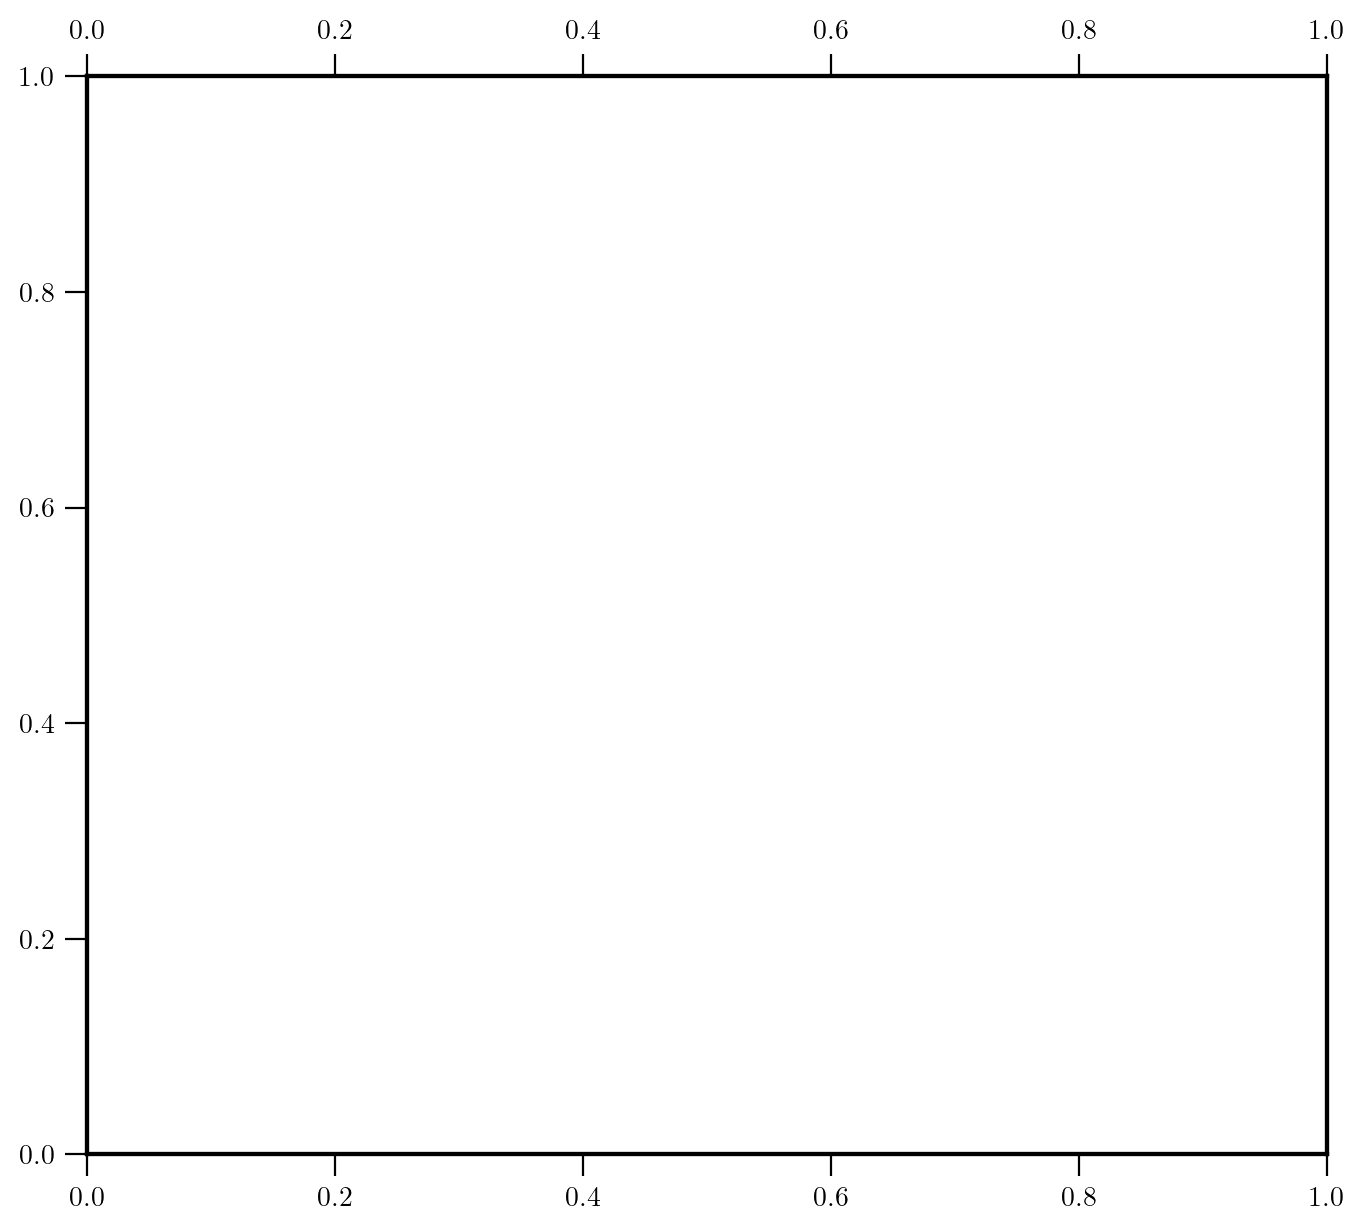

In [15]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

cdm = ax.semilogx(wdm_transfers['6.5'][:,0],cdm_transfers_wdm['6.5']/cdm_transfers_wdm['6.5'],
            c='k',ls=':',lw=2,label=r'$\mathrm{CDM}$')

for mass in ['6.5']:
    ind = ~np.isnan(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])
    ax.semilogx(wdm_transfers[mass][:,0][ind]*0.7,(wdm_transfers[mass][:,1]/cdm_transfers_wdm[mass])[ind],
                 lw=2,c=sim_colors['wdm_{}'.format(mass)],alpha=0.35)

halfmode = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='--',c=sim_colors['idm_1e-4GeV'],label='$\mathrm{Matched\ WDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)

envelope = ax.semilogx(idm_transfers['2']['1e-4GeV']['envelope'][:,0]*0.7,
             -1.*(idm_transfers['2']['1e-4GeV']['envelope'][:,1]/cdm_transfers_idm['2']['1e-4GeV']['envelope']),
             lw=2,ls='-',c=sim_colors['idm_1e-4GeV'],label='$\mathrm{IDM}$')#+'\n'+r'$\sigma_0=2.2\times 10^{-27}\ \mathrm{cm}^2$',zorder=999)


kvec = np.logspace(0, np.log10(500), 1000)
for model in models:
    if model == 'cdm':
        continue
    elif 'n2' in model:
        continue
    else:
        ax.plot(kvec*0.7, transfer(kvec, masses_halfmode[model])**2, color=sim_colors[model],linestyle='--')
    
m4 = ax.semilogx(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode']),
             lw=2,c=sim_colors['idm_1e-4GeV'],label='$m_{\mathrm{DM}}=10^{-4}\ \mathrm{GeV}$')

print('4','1e-4GeV','halfmode')
print((idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-4GeV']['halfmode'][:,0]**3*idm_transfers['4']['1e-4GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode'])-0.25))
k_short = idm_transfers['4']['1e-4GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-4GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-4GeV']['halfmode'])[minimum_ind:]
print((idm_transfers['4']['1e-4GeV']['halfmode'][:,0]*0.7)[halfmode_ind])
print(k_short[46])
print(idm_transfer_short[46])
print('\n')

m2 = ax.semilogx(idm_transfers['4']['1e-2GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode']),
             lw=2,c=sim_colors['idm_1e-2GeV'],label='$m_{\mathrm{DM}}=10^{-2}\ \mathrm{GeV}$')

print('4','1e-2GeV','halfmode')
print((idm_transfers['4']['1e-2GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['4']['1e-2GeV']['halfmode'][:,0]**3*idm_transfers['4']['1e-2GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode'])-0.25))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode'])-0.9))
k_short = idm_transfers['4']['1e-2GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1e-2GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1e-2GeV']['halfmode'])[minimum_ind:]
print(k_short[50])
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

m0 = ax.semilogx(idm_transfers['4']['1GeV']['halfmode'][:,0]*0.7,
             (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode']),
             lw=2,c=sim_colors['idm_1GeV'],label='$m_{\mathrm{DM}}=10^{0}\ \mathrm{GeV}$')

print('4','1GeV','halfmode')
print((idm_transfers['4']['1GeV']['halfmode'][:,0]*0.7)[np.argmax(idm_transfers['4']['1GeV']['halfmode'][:,0]**3*idm_transfers['4']['1GeV']['halfmode'][:,1])])
halfmode_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])-0.9))
minimum_ind = np.argmin(np.abs((idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])-0.1))
k_short = idm_transfers['4']['1GeV']['envelope'][:,0][halfmode_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])[halfmode_ind:]
print(k_short[55])
k_short = idm_transfers['4']['1GeV']['halfmode'][:,0][minimum_ind:]*0.7
idm_transfer_short = (idm_transfers['4']['1GeV']['halfmode'][:,1]/cdm_transfers_idm['4']['1GeV']['halfmode'])[minimum_ind:]
print(k_short[np.argmax(idm_transfer_short)])
print(np.max(idm_transfer_short))
print('\n')

ax.set_xlim(1,200)
ax.set_ylim(0,1.05)

ax.set_xticks([1,10,100])
ax.set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$'],fontsize=17)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([r'$0.0$',r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'],fontsize=17)

ax2.set_xscale('log')
ax2.set_xlim(1,200)
ax2.set_xticks([k_M(1e12),k_M(1e10),k_M(1e8),k_M(1e6)])
ax2.set_xticklabels([r'$10^{12}$',r'$10^{10}$',r'$10^{8}$',r'$10^6$'],fontsize=17)
ax2.set_xticks([k_M(1e11),k_M(1e9),k_M(1e7)],minor=True)
ax2.set_xticklabels(['','',''],fontsize=17,minor=True)
ax2.set_xlabel(r'$M\ [M_{\mathrm{\odot}}]$',fontsize=22,labelpad=12)

ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$',fontsize=22,labelpad=8)
ax.set_ylabel(r'$\mathcal{T}^2_{\mathrm{IDM}}(k) = P_{\mathrm{IDM}}(k)/P_{\mathrm{CDM}}(k)$',fontsize=22,labelpad=12)
first_legend = plt.legend(handles=[cdm[0],m4[0],m2[0],m0[0]], loc=3, fontsize=16, frameon=False)
plt.gca().add_artist(first_legend)
plt.legend(handles=[envelope[0],halfmode[0]], loc=2, fontsize=16, frameon=False, bbox_to_anchor = (0.0,0.95))
ax.text(1.2,0.335,r'$n=4,\ \mathrm{half}$-$\mathrm{mode}$',fontsize=20)

#plt.savefig('/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/transfer_idm_n4_halfmode_wdm.pdf')
plt.show()

### Fitting attempt

In [16]:
def sampler_to_dataframe(sampler, columns=None):
    """
    Convert output of an emcee sampler to a Pandas DataFrame.

    Parameters
    ----------
    sampler : emcee.EnsembleSampler or emcee.PTSampler instance
        Sampler instance form which MCMC has already been run.

    Returns
    -------
    output : DataFrame
        Pandas DataFrame containing the samples. Each column is
        a variable, except: 'lnprob' and 'chain' for an
        EnsembleSampler, and 'lnlike', 'lnprob', 'beta_ind',
        'beta', and 'chain' for a PTSampler. These contain obvious
        values.
    """
    invalid_column_names = ['lnprob', 'chain', 'lnlike', 'beta',
                            'beta_ind']
    if np.any([x in columns for x in invalid_column_names]):
            raise RuntimeError('You cannot name columns with any of these: '
                                    + '  '.join(invalid_column_names))

    if columns is None:
        columns = list(range(sampler.chain.shape[-1]))

    if isinstance(sampler, emcee.EnsembleSampler):
        n_walkers, n_steps, n_dim = sampler.chain.shape

        df = pd.DataFrame(data=sampler.flatchain, columns=columns)
        df['lnprob'] = sampler.flatlnprobability
        df['chain'] = np.concatenate([i * np.ones(n_steps, dtype=int)
                                                for i in range(n_walkers)])
    elif isinstance(sampler, emcee.PTSampler):
        n_temps, n_walkers, n_steps, n_dim = sampler.chain.shape

        df = pd.DataFrame(
            data=sampler.flatchain.reshape(
                (n_temps * n_walkers * n_steps, n_dim)),
            columns=columns)
        df['lnlike'] = sampler.lnlikelihood.flatten()
        df['lnprob'] = sampler.lnprobability.flatten()

        beta_inds = [i * np.ones(n_steps * n_walkers, dtype=int)
                     for i, _ in enumerate(sampler.betas)]
        df['beta_ind'] = np.concatenate(beta_inds)

        df['beta'] = sampler.betas[df['beta_ind']]

        chain_inds = [j * np.ones(n_steps, dtype=int)
                      for i, _ in enumerate(sampler.betas)
                      for j in range(n_walkers)]
        df['chain'] = np.concatenate(chain_inds)
    else:
        raise RuntimeError('Invalid sample input.')

    return df

In [17]:
integrals = {}
integrals_coarse = {}
integrals_measured = {}

for num in halo_nums:
    integrals[num] = {}
    integrals_coarse[num] = {}
    integrals_measured[num] = {}
    for model in models:
        if model != 'cdm':
            integrals[num][model] = {}
            integrals_coarse[num][model] = {}
            integrals_measured[num][model] = {}
            for method in methods:
                data = np.array([np.log10(sim_data[num][model][method][2]['Mpeak']/0.7),
                          np.log10(sim_data[num][model][method][2]['Mvir']/(0.7))]).T
        
                # Perform KDE
                kde = KernelDensity(bandwidth=0.2)
                kde.fit(data,sample_weight=np.log10(sim_data[num][model][method][2]['Mpeak']/(0.7)))
            
                # Define the x values for which you want to estimate the integral
                x_values = np.linspace(np.log10(1.2e8),np.log10(sim_data[num][model][method][0]['mvir'][0]/(2.*0.7)),100)
                x_values_coarse = np.linspace(np.log10(1.2e8),np.log10(sim_data[num][model][method][0]['mvir'][0]/(2.*0.7)),10)
            
                # Specify the y value up to which you want to integrate
                specified_y = np.log10(1.2e8)
            
                # Function to estimate the integral at a given x value
                def estimate_integral(x,data):
                    if x > np.max(data):
                        return 0.
                    else:
                        # Generate y values for the specified x
                        y_values = np.linspace(min(data[:,1]), specified_y, 100)
                        y_values_all = np.linspace(min(data[:, 1]), max(data[:, 1]), 100)
                        
                        # Compute the PDF values at each (x, y) pair
                        xy_pairs = np.column_stack([np.full_like(y_values, x), y_values])
                        log_pdf_values = kde.score_samples(xy_pairs)
                        pdf_values = np.exp(log_pdf_values)
                        
                        # Integrate the PDF values along the y-axis
                        integral = trapezoid(pdf_values, y_values)
                
                        ###
                    
                        xy_pairs = np.column_stack([np.full_like(y_values_all, x), y_values_all])
                        log_pdf_values = kde.score_samples(xy_pairs)
                        pdf_values = np.exp(log_pdf_values)
                        
                        # Integrate the PDF values along the y-axis
                        integral_tot = trapezoid(pdf_values, y_values_all)
                        
                        return integral/integral_tot
            
                # Estimate integrals for each x value
                ind = (sim_data[num][model][method][2]['Mvir']/0.7 > 1.2e8)
                integrals[num][model][method] = [estimate_integral(x,data) for x in x_values]
                integrals_coarse[num][model][method] = [estimate_integral(x,data) for x in x_values_coarse]
                integrals_measured[num][model][method] = [estimate_integral(x,data) for x in np.log10(sim_data[num][model][method][2]['Mpeak'][ind]/0.7)]
            
                # Example: Print estimated integral at x = 0
                x_index = np.abs(x_values - 9).argmin()
                print(f"Estimated integral log(M) = 9 for {num} {model}: {integrals[num][model][method][x_index]}")
        else:
            for model in ['cdm']:
                data = np.array([np.log10(sim_data[num][model][2]['Mpeak']/0.7),
                              np.log10(sim_data[num][model][2]['Mvir']/(0.7))]).T
            
                # Perform KDE
                kde = KernelDensity(bandwidth=0.2)
                kde.fit(data,sample_weight=np.log10(sim_data[num][model][2]['Mpeak']/(0.7)))
                
                # Define the x values for which you want to estimate the integral
                x_values = np.linspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),100)
                x_values_coarse = np.linspace(np.log10(1.2e8),np.log10(sim_data[num][model][0]['mvir'][0]/(2.*0.7)),10)
                
                # Specify the y value up to which you want to integrate
                specified_y = np.log10(1.2e8)
                
                # Function to estimate the integral at a given x value
                def estimate_integral(x,data):
                    if x > np.max(data):
                        return 0.
                    else:
                        # Generate y values for the specified x
                        y_values = np.linspace(min(data[:,1]), specified_y, 100)
                        y_values_all = np.linspace(min(data[:, 1]), max(data[:, 1]), 100)
                        
                        # Compute the PDF values at each (x, y) pair
                        xy_pairs = np.column_stack([np.full_like(y_values, x), y_values])
                        log_pdf_values = kde.score_samples(xy_pairs)
                        pdf_values = np.exp(log_pdf_values)
                        
                        # Integrate the PDF values along the y-axis
                        integral = trapezoid(pdf_values, y_values)
                            ###
            
                        xy_pairs = np.column_stack([np.full_like(y_values_all, x), y_values_all])
                        log_pdf_values = kde.score_samples(xy_pairs)
                        pdf_values = np.exp(log_pdf_values)
                        
                        # Integrate the PDF values along the y-axis
                        integral_tot = trapezoid(pdf_values, y_values_all)
                        
                        return integral/integral_tot
        
            # Estimate integrals for each x value
            ind = (sim_data[num][model][2]['Mvir']/0.7 > 1.2e8)
            integrals[num][model] = [estimate_integral(x,data) for x in x_values]
            integrals_coarse[num][model] = [estimate_integral(x,data) for x in x_values_coarse]
            integrals_measured[num][model] = [estimate_integral(x,data) for x in np.log10(sim_data[num][model][2]['Mpeak'][ind]/0.7)]
            
            # Example: Print estimated integral at x = 0
            x_index = np.abs(x_values - 9).argmin()
            print(f"Estimated integral log(M) = 9 for {num} {model}: {integrals[num][model][x_index]}")

Estimated integral log(M) = 9 for Halo004 idm_n2_1e-4GeV: 0.3194797475343997
Estimated integral log(M) = 9 for Halo004 idm_n2_1e-4GeV: 0.3476959668732081
Estimated integral log(M) = 9 for Halo004 idm_n2_1e-2GeV: 0.3017400368813804
Estimated integral log(M) = 9 for Halo004 idm_n2_1e-2GeV: 0.230322690183508
Estimated integral log(M) = 9 for Halo004 idm_n2_1GeV: 0.2985995754037934
Estimated integral log(M) = 9 for Halo004 idm_n2_1GeV: 0.3603447367082922
Estimated integral log(M) = 9 for Halo004 idm_1e-4GeV: 0.3256101278861078
Estimated integral log(M) = 9 for Halo004 idm_1e-4GeV: 0.34615894957709414
Estimated integral log(M) = 9 for Halo004 idm_1e-2GeV: 0.2978774529162888
Estimated integral log(M) = 9 for Halo004 idm_1e-2GeV: 0.237624289934256
Estimated integral log(M) = 9 for Halo004 idm_1GeV: 0.30613171587244214
Estimated integral log(M) = 9 for Halo004 idm_1GeV: 0.2435683616052892
Estimated integral log(M) = 9 for Halo004 cdm: 0.32442113812518636
Estimated integral log(M) = 9 for Halo1

In [18]:
def dNdlogMpeak(a,b,Mhm,x2,integrals,host):
    return (1.-np.array(integrals))*(a/100)*(10.**x2/(host['mvir'][0]/0.7))**(-1.*b)*np.exp(-50.*(10.**x2/(host['mvir'][0]/0.7))**(4.))*(1.+(2.5*10.**Mhm/10.**x2)**0.9)**(-1.*1.0)

In [19]:
### CDM + WDM
for model in models:
    if model == 'cdm':
        continue
    for method in methods:
        def log_likelihood(theta, x=x):#, wdm_shmf_suppression, wdm_shmf_suppression_err):
            a1, b1, a2, b2, a3, b3, Mhm = theta
            lnlike = 0.
            Nsim = 0.
            Nmodel = 0.
            Summation = 0.
            for i,num in enumerate(halo_nums):
                if i == 0:
                    a = a1
                    b = b1
                elif i == 1:
                    a = a2
                    b = b2
                elif i == 2:
                    a = a3
                    b = b3
                ###
                measured_masses = sim_data[num][model][method][2]['Mpeak']/0.7
                ind = sim_data[num][model][method][2]['Mvir']/0.7 > 1.2e8
                measured_masses = measured_masses[ind]
                measured_model = dNdlogMpeak(a,b,Mhm,np.log10(measured_masses),integrals_measured[num][model][method],
                                             sim_data[num][model][method][0])
                ###
                x2 = np.logspace(np.log10(1.2e8),np.log10(sim_data[num][model][method][0]['mvir'][0]/(2.*0.7)),100)
                tot_model = dNdlogMpeak(a,b,Mhm,np.log10(x2),integrals[num][model][method],
                                        sim_data[num][model][method][0])
                Nsim += 1.*len(measured_masses)
                Nmodel += np.trapz(tot_model,np.log10(x2))
                ###
                Summation += np.sum(np.log(measured_model))
            ###
            lnlike = -Nmodel + Summation    
            return lnlike

        def log_prior(theta):
            a1, b1, a2, b2, a3, b3, Mhm = theta
        #     a, b = theta
            if 1 < a1 < 50 and 0.1 < b1 < 1.5 and 1 < a2 < 50 and 0.1 < b2 < 1.5 and 1 < a3 < 50 and 0.1 < b3 < 1.5 and 3. < Mhm < 10.:
                return np.log(1.0/(1.0+(b1**2))) + np.log(1.0/(1.0+(b2**2))) + np.log(1.0/(1.0+(b3**2)))
            return -np.inf
        
        def log_probability(theta):
            lp = log_prior(theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp + log_likelihood(theta)
        
        x0=np.array([5, 0.9, 5, 0.9, 5, 0.9, 6.])
        
        pos = x0 + 1e-2 * np.random.randn(100, 7)
        nwalkers, ndim = pos.shape
        
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
        sampler.run_mcmc(pos, 10000, progress=True);
        
        ###
        
        flat_samples = sampler.get_chain(discard=1000, flat=True)
        # np.save('/central/groups/carnegie_poc/enadler/ncdm_resims/analysis/flat_samples_wdm.npy',flat_samples)
        
        print(flat_samples[np.argmax(sampler.get_log_prob(discard=1000, flat=True))])
        # np.save('/central/groups/carnegie_poc/enadler/ncdm_resims/analysis/log_prob_wdm.npy'
        #         ,sampler.get_log_prob(discard=10000, flat=True))

        ###
        
        df_mcmc = sampler_to_dataframe(sampler, columns=[r"$a_1$",r"$b_1$",r"$a_2$",r"$b_2$",r"$a_3$",r"$b_3$",r"$M_{\mathrm{hm}}$"])
        df_mcmc = df_mcmc.drop('chain', axis=1)
        df_mcmc = df_mcmc.rename(columns={"lnprob": "log_posterior"})
        df_mcmc['log_posterior'].values[~np.isinf(df_mcmc['log_posterior'].values)]
        # df_mcmc.to_pickle('/central/groups/carnegie_poc/enadler/ncdm_resims/analysis/df_wdm.pkl')
        ###
        print(model, method)
        df_mcmc = df_mcmc.drop(['log_posterior'], axis=1)
        c = ChainConsumer()
        c.add_chain(df_mcmc)#, parameters=[r"$a$",r"$b$",r"$\alpha$", r"$\beta$", r"$\gamma$"])
        
        c.configure(colors=[sim_colors['wdm_3'], sim_colors['wdm_4']], shade=[True,False], bar_shade=True,spacing=1.0,
                        diagonal_tick_labels=False, tick_font_size=14, label_font_size=18, sigma2d=False,max_ticks=4, 
                        summary=True,kde=False)
        fig = c.plotter.plot(figsize=(8,8), extents=[[1,50],[0.1,1.5],[1,50],[0.1,1.5],[1,50],[0.1,1.5],[3,10]],display=True)#, #truth=[2.7,1.,0.99]
                             #filename='/central/groups/carnegie_poc/enadler/ncdm_resims/new_figures/wdm_shmf_posterior.pdf')

100%|██████████| 10000/10000 [05:32<00:00, 30.08it/s]


[18.29781121  0.90033362 10.03166837  0.9551644  25.41652796  0.80400821
  7.7856376 ]
idm_n2_1e-4GeV halfmode


AttributeError: 'DataFrame' object has no attribute 'name'

In [ ]:
len(sim_data['Halo004']['idm_n2_1e-4GeV']['halfmode'][2][sim_data['Halo004']['idm_n2_1e-4GeV']['halfmode'][2]['Mvir']/0.7>1.2e8])

In [ ]:
len(sim_data['Halo004']['cdm'][2][sim_data['Halo004']['cdm'][2]['Mvir']/0.7>1.2e8])




In [ ]:
cdm_mpeaks = sim_data['Halo004']['cdm'][2][sim_data['Halo004']['cdm'][2]['Mvir']/0.7>1.2e8]['Mpeak']/0.7

for model in models:
    if model == 'cdm':
        continue
    counts = []
    for method in methods:
        print(model,method)
        idm_num = len(sim_data['Halo004'][model][method][2][sim_data['Halo004'][model][method][2]['Mvir']/0.7>1.2e8])
        for mwdm in np.linspace(2,15,10000):
            weights = (1.+(2.5*Mhm(mwdm)/cdm_mpeaks)**0.9)**(-1.*1.0)
            counts.append(np.sum(weights))
        print(idm_num,np.array(counts)[np.argmin(np.abs(np.array(counts)-idm_num))],
              np.linspace(2,15,10000)[np.argmin(np.abs(np.array(counts)-idm_num))])